# Preprocessing - Document Segmentation

This module will be used for the initial level of document segmentation.

The target document is Course Descriptor.

Objective:
* Identify Tables (Course Code, Title and Assessment)
* Identify Paragraphs (Everything else... e.g.: Aim, Learning Outcomes, Indicative Content)

Next Step:
 Break each line of initial segmentation to words and characters

### Connect to Google Drive

Google drive contains the input data created using Course Descriptor

In [1]:
# do not run when we import this package as module
if __name__ == '__main__':
  # Connect Google Drive
  from google.colab import drive
  drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
if __name__ == '__main__':
  ## Load all ipynb files from Google Drive to Colab environment
  import os
  import shutil

  def find_and_copy_files(src_folder, dest_folder, file_extension):
    for foldername, subfolders, filenames in os.walk(src_folder):
        for filename in filenames:
            if filename.endswith(file_extension):
                src_file = os.path.join(foldername, filename)
                dest_file = os.path.join(dest_folder, filename)
                try:
                    shutil.copy2(src_file, dest_file)  # Use shutil.copy if you don't need metadata
                    print(f"Copied: {src_file} to {dest_file}")
                except Exception as e:
                    print(f"Error copying {src_file}: {e}")

In [3]:
if __name__ == '__main__':
  src_folder = '/content/gdrive/MyDrive/OWR/source'
  dest_folder = '/content'
  file_extension = '.ipynb'

  # Call the function to find and copy files
  find_and_copy_files(src_folder, dest_folder, file_extension)

Copied: /content/gdrive/MyDrive/OWR/source/input_generator/owr_input_generator.ipynb to /content/owr_input_generator.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/owr_model_v2.ipynb to /content/owr_model_v2.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/owr_segmentation_v3.ipynb to /content/owr_segmentation_v3.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_CNN_classification.ipynb to /content/owr_preprocess_skew_CNN_classification.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_CNN_regression.ipynb to /content/owr_preprocess_skew_CNN_regression.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_cv.ipynb to /content/owr_preprocess_skew_cv.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocessing.ipynb to /content/owr_preprocessing.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocess

### Import Libraries

In [4]:
import os
import json
import random
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
import math
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import clear_output as cls

## Import Packages/Modules from Colab Environment

In [5]:
if __name__ == '__main__':
  !pip install import_ipynb
  import import_ipynb

cls()

In [6]:
if __name__ == '__main__':
  # Import Colab Models
  import owr_preprocessing as BPP

importing Jupyter notebook from owr_preprocessing.ipynb


In [7]:
def showImg(img, cmap=None):
    plt.imshow(img, cmap=cmap, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

### Global Parameters

In [8]:
# Temporary Parameters

tmpImgPaath = '/content/gdrive/MyDrive/OWR/data/tmp_tilt/page_97.png'

# Read the image
tmpImg = cv2.imread(tmpImgPaath)

# Get the current size of the image
current_height, current_width, _ = tmpImg.shape

# Calculate the new size (3/2 times the current size)
new_height = int(current_height * 3 / 2)
new_width = int(current_width * 3 / 2)

# Resize the image
tmpImg = cv2.resize(tmpImg, (new_width, new_height))



In [9]:
# Convert image to Grayscale
imgGray = BPP.set_grayscale(tmpImg)

# Binarization
imgBinary = BPP.set_Adaptive_Binarization(imgGray)

In [10]:
# Define Kernel for Morphological Operations

# Image width
kernel_length = np.array(imgBinary).shape[1]//80

# A verticle kernel of (1 x kernel_length)
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,kernel_length))

# A horizontal kernel of (kernel_length x 1)
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length,1))

# A kernel of (3 x 3) ones
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

In [11]:
# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(imgBinary, verticle_kernel, iterations=3)
vertical_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)

# Morphological operation to detect horizontal lines from an image
img_temp2 = cv2.erode(imgBinary, hori_kernel, iterations=3)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)


In [ ]:
# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha


# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(vertical_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)

(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


In [ ]:
# Find contours for image, which will detect all the boxes
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
'''
0 : Star [1,-1,-1,-1]
… Next — Outer Square (1)
… Previous — No Contour(-1)
… Child — No Child (-1)
… Parent — No Parent (-1)

'''

'\n0 : Star [1,-1,-1,-1]\n… Next — Outer Square (1)\n… Previous — No Contour(-1)\n… Child — No Child (-1)\n… Parent — No Parent (-1)\n\n'

In [ ]:
# Initialize lists to store outer rectangles and their child contours
outer_rectangles = []
child_contours = []

# Iterate through the hierarchy to find outer rectangles and their children
for i in range(len(contours)):

    if hierarchy[0][i][3] == 0:  # Check if the contour has no parent (i.e., it's an outer contour)
        # Calculate the bounding rectangle of the outer contour
        x, y, w, h = cv2.boundingRect(contours[i])
        outer_rectangles.append((x, y, x + w, y + h))

        # Find child contours of the outer contour
        children = []
        for j in range(len(contours)):
            if hierarchy[0][j][3] == i:  # Check if contour j is a child of contour i
                children.append(j)
        child_contours.append(children)

In [ ]:
tmpImageOuter = tmpImg.copy()
for rect in outer_rectangles:
    x1, y1, x2, y2 = rect
    cv2.rectangle(tmpImageOuter, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw green rectangles

In [ ]:
outer_rectangles

[(274, 1635, 1349, 1847), (166, 103, 1725, 182)]

In [ ]:
child_contours

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [18, 19]]

In [ ]:
# Sort the outer rectangles based on their top-left coordinates (y, x)
outer_rectangles = sorted(outer_rectangles, key=lambda rect: (rect[1], rect[0]))

# Sort the child contours based on their top-left coordinates (y, x)
for i in range(len(child_contours)):
    child_contours[i] = sorted(child_contours[i], key=lambda child_index: (contours[child_index][0][0][1], contours[child_index][0][0][0]))

In [ ]:
outer_rectangles

[(166, 103, 1725, 182), (274, 1635, 1349, 1847)]

In [ ]:
child_contours

[[16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2], [19, 18]]

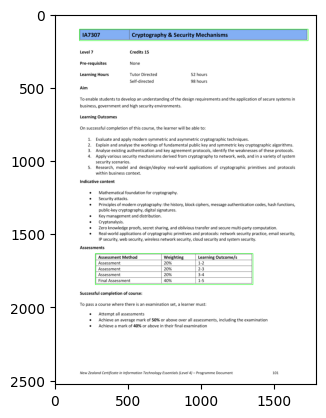

In [ ]:
plt.imshow(tmpImageOuter, )

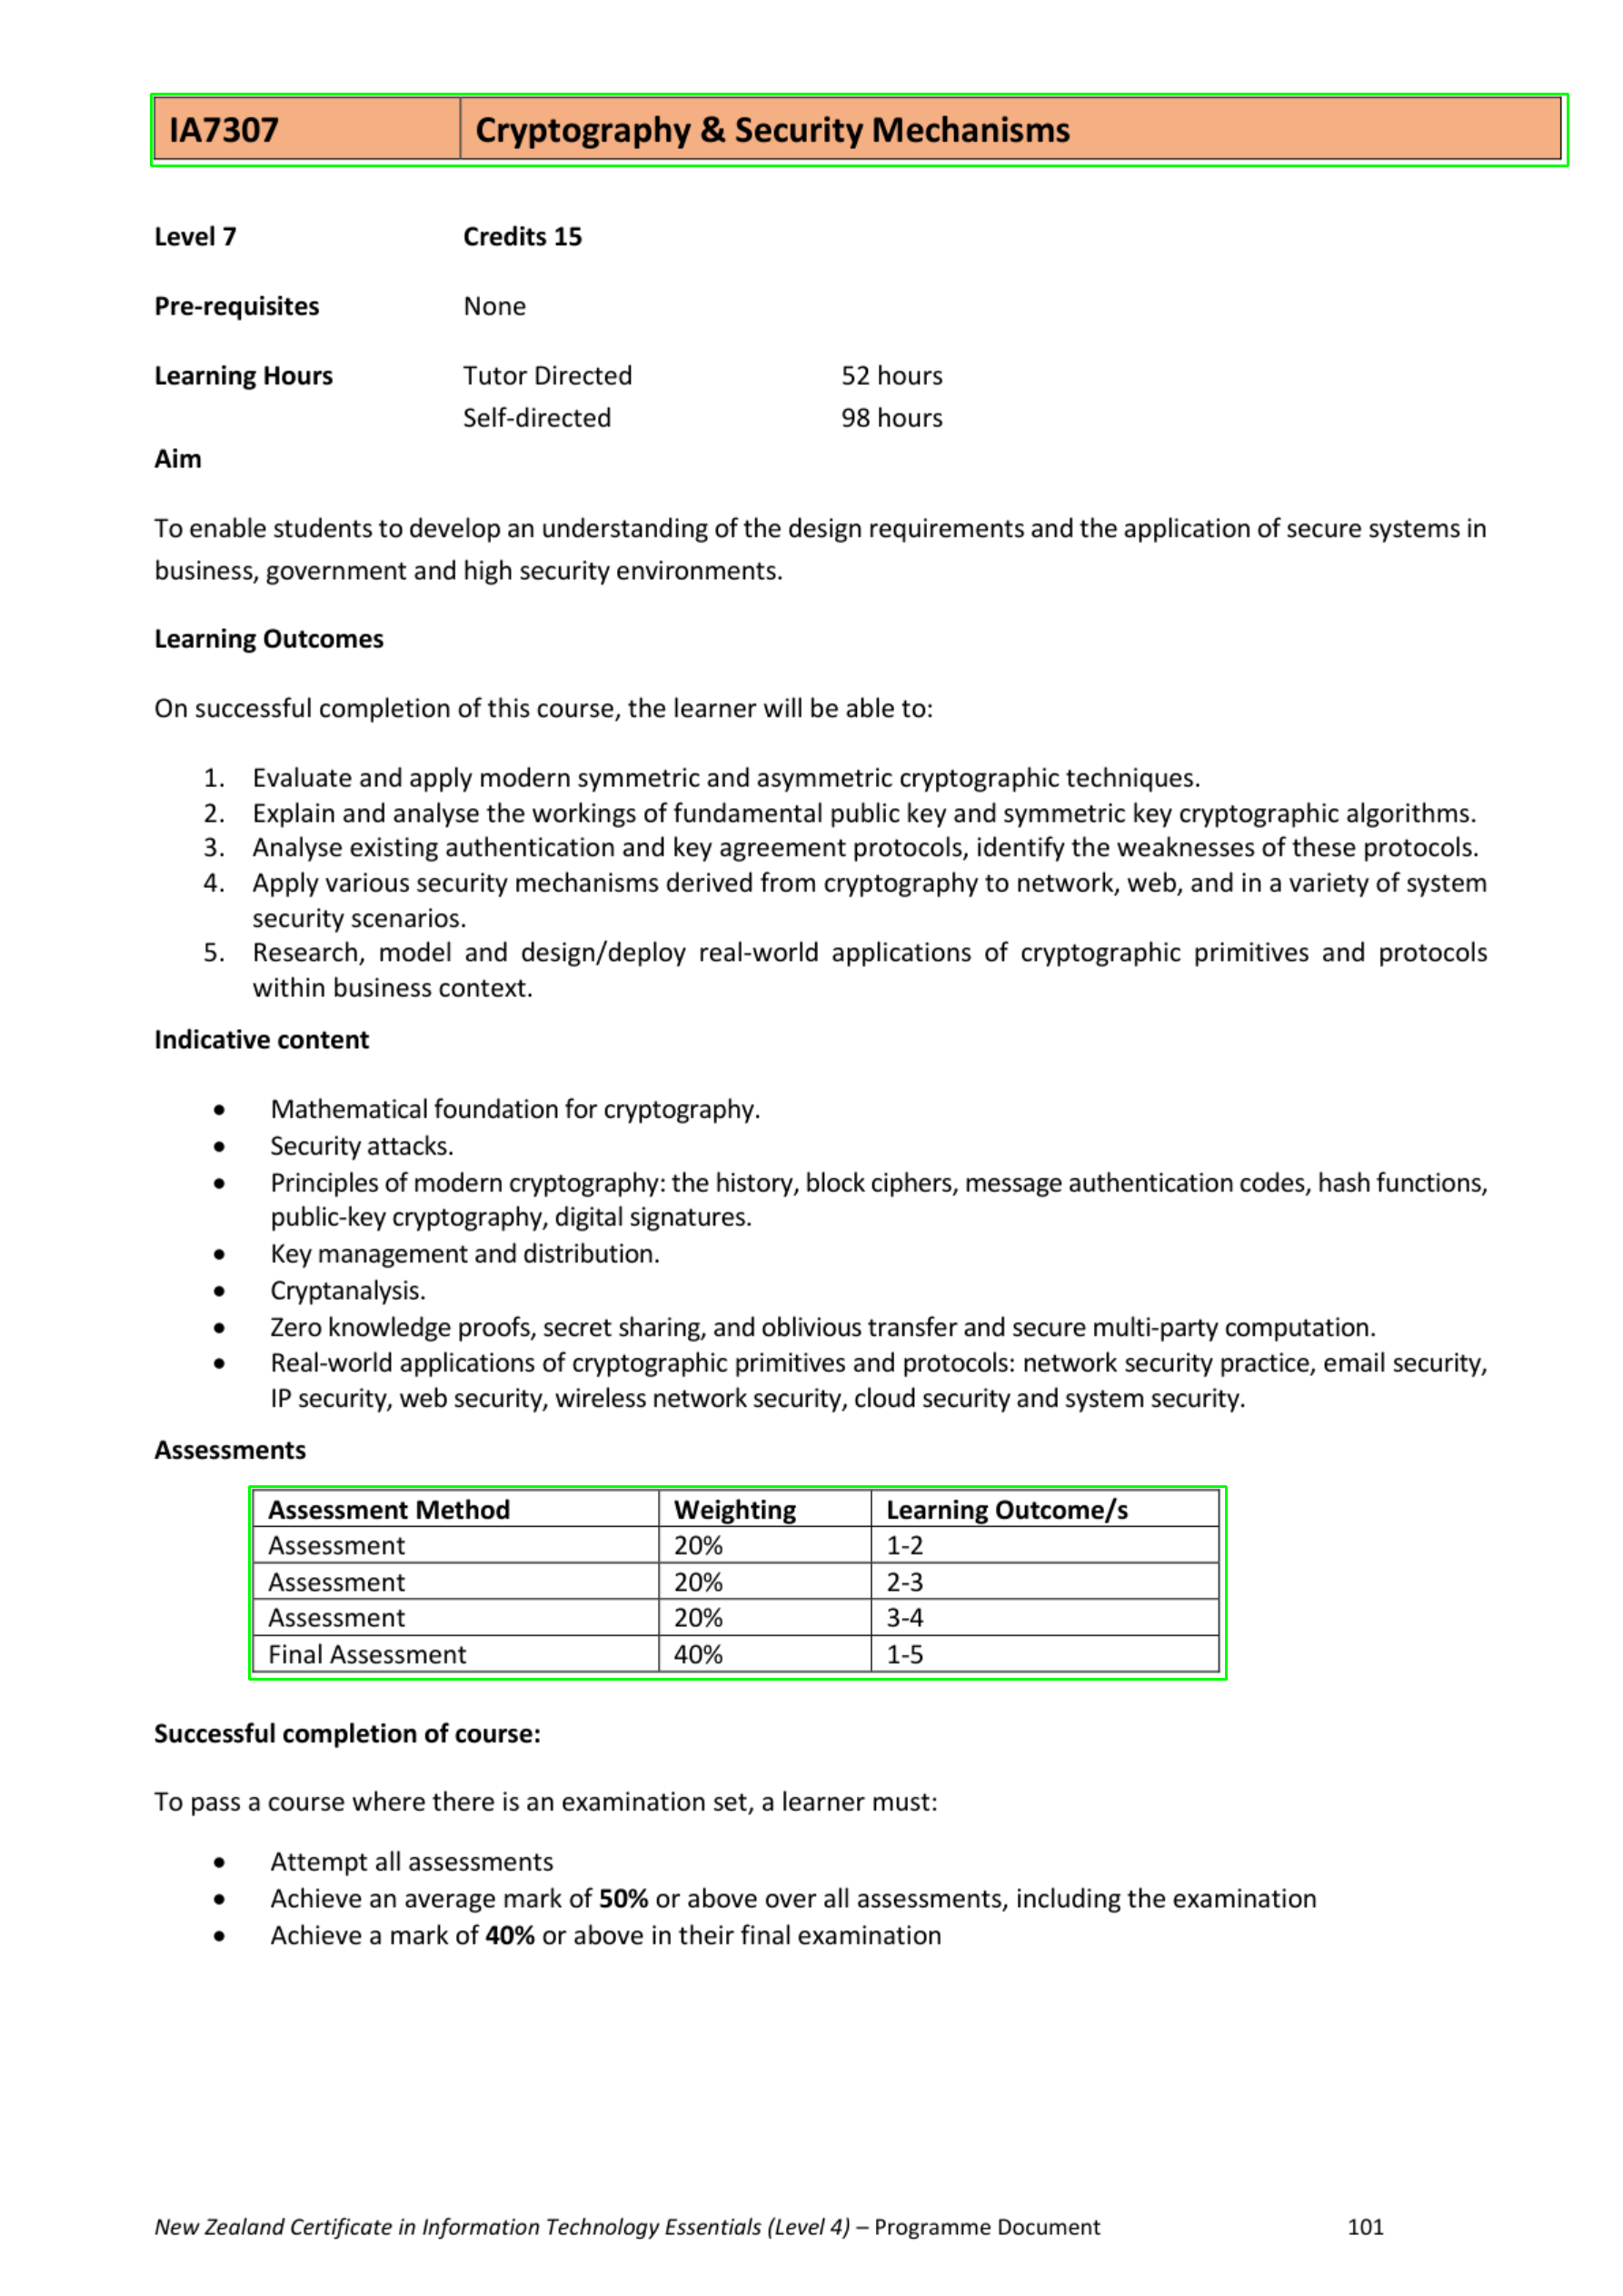

In [ ]:
cv2_imshow(tmpImageOuter)

In [ ]:
tmpImageInner = tmpImg.copy()
# Draw child contours on the original image
for children in child_contours:
    for child_index in children:
        child_contour = contours[child_index]
        x, y, w, h = cv2.boundingRect(child_contour)
        cv2.rectangle(tmpImageInner, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Draw red rectangles

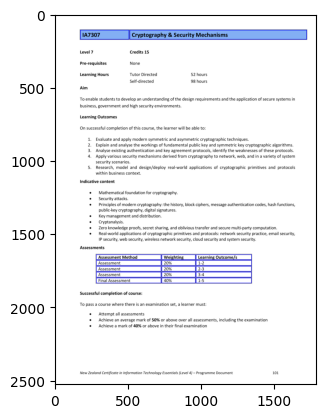

In [ ]:
plt.imshow(tmpImageInner, )

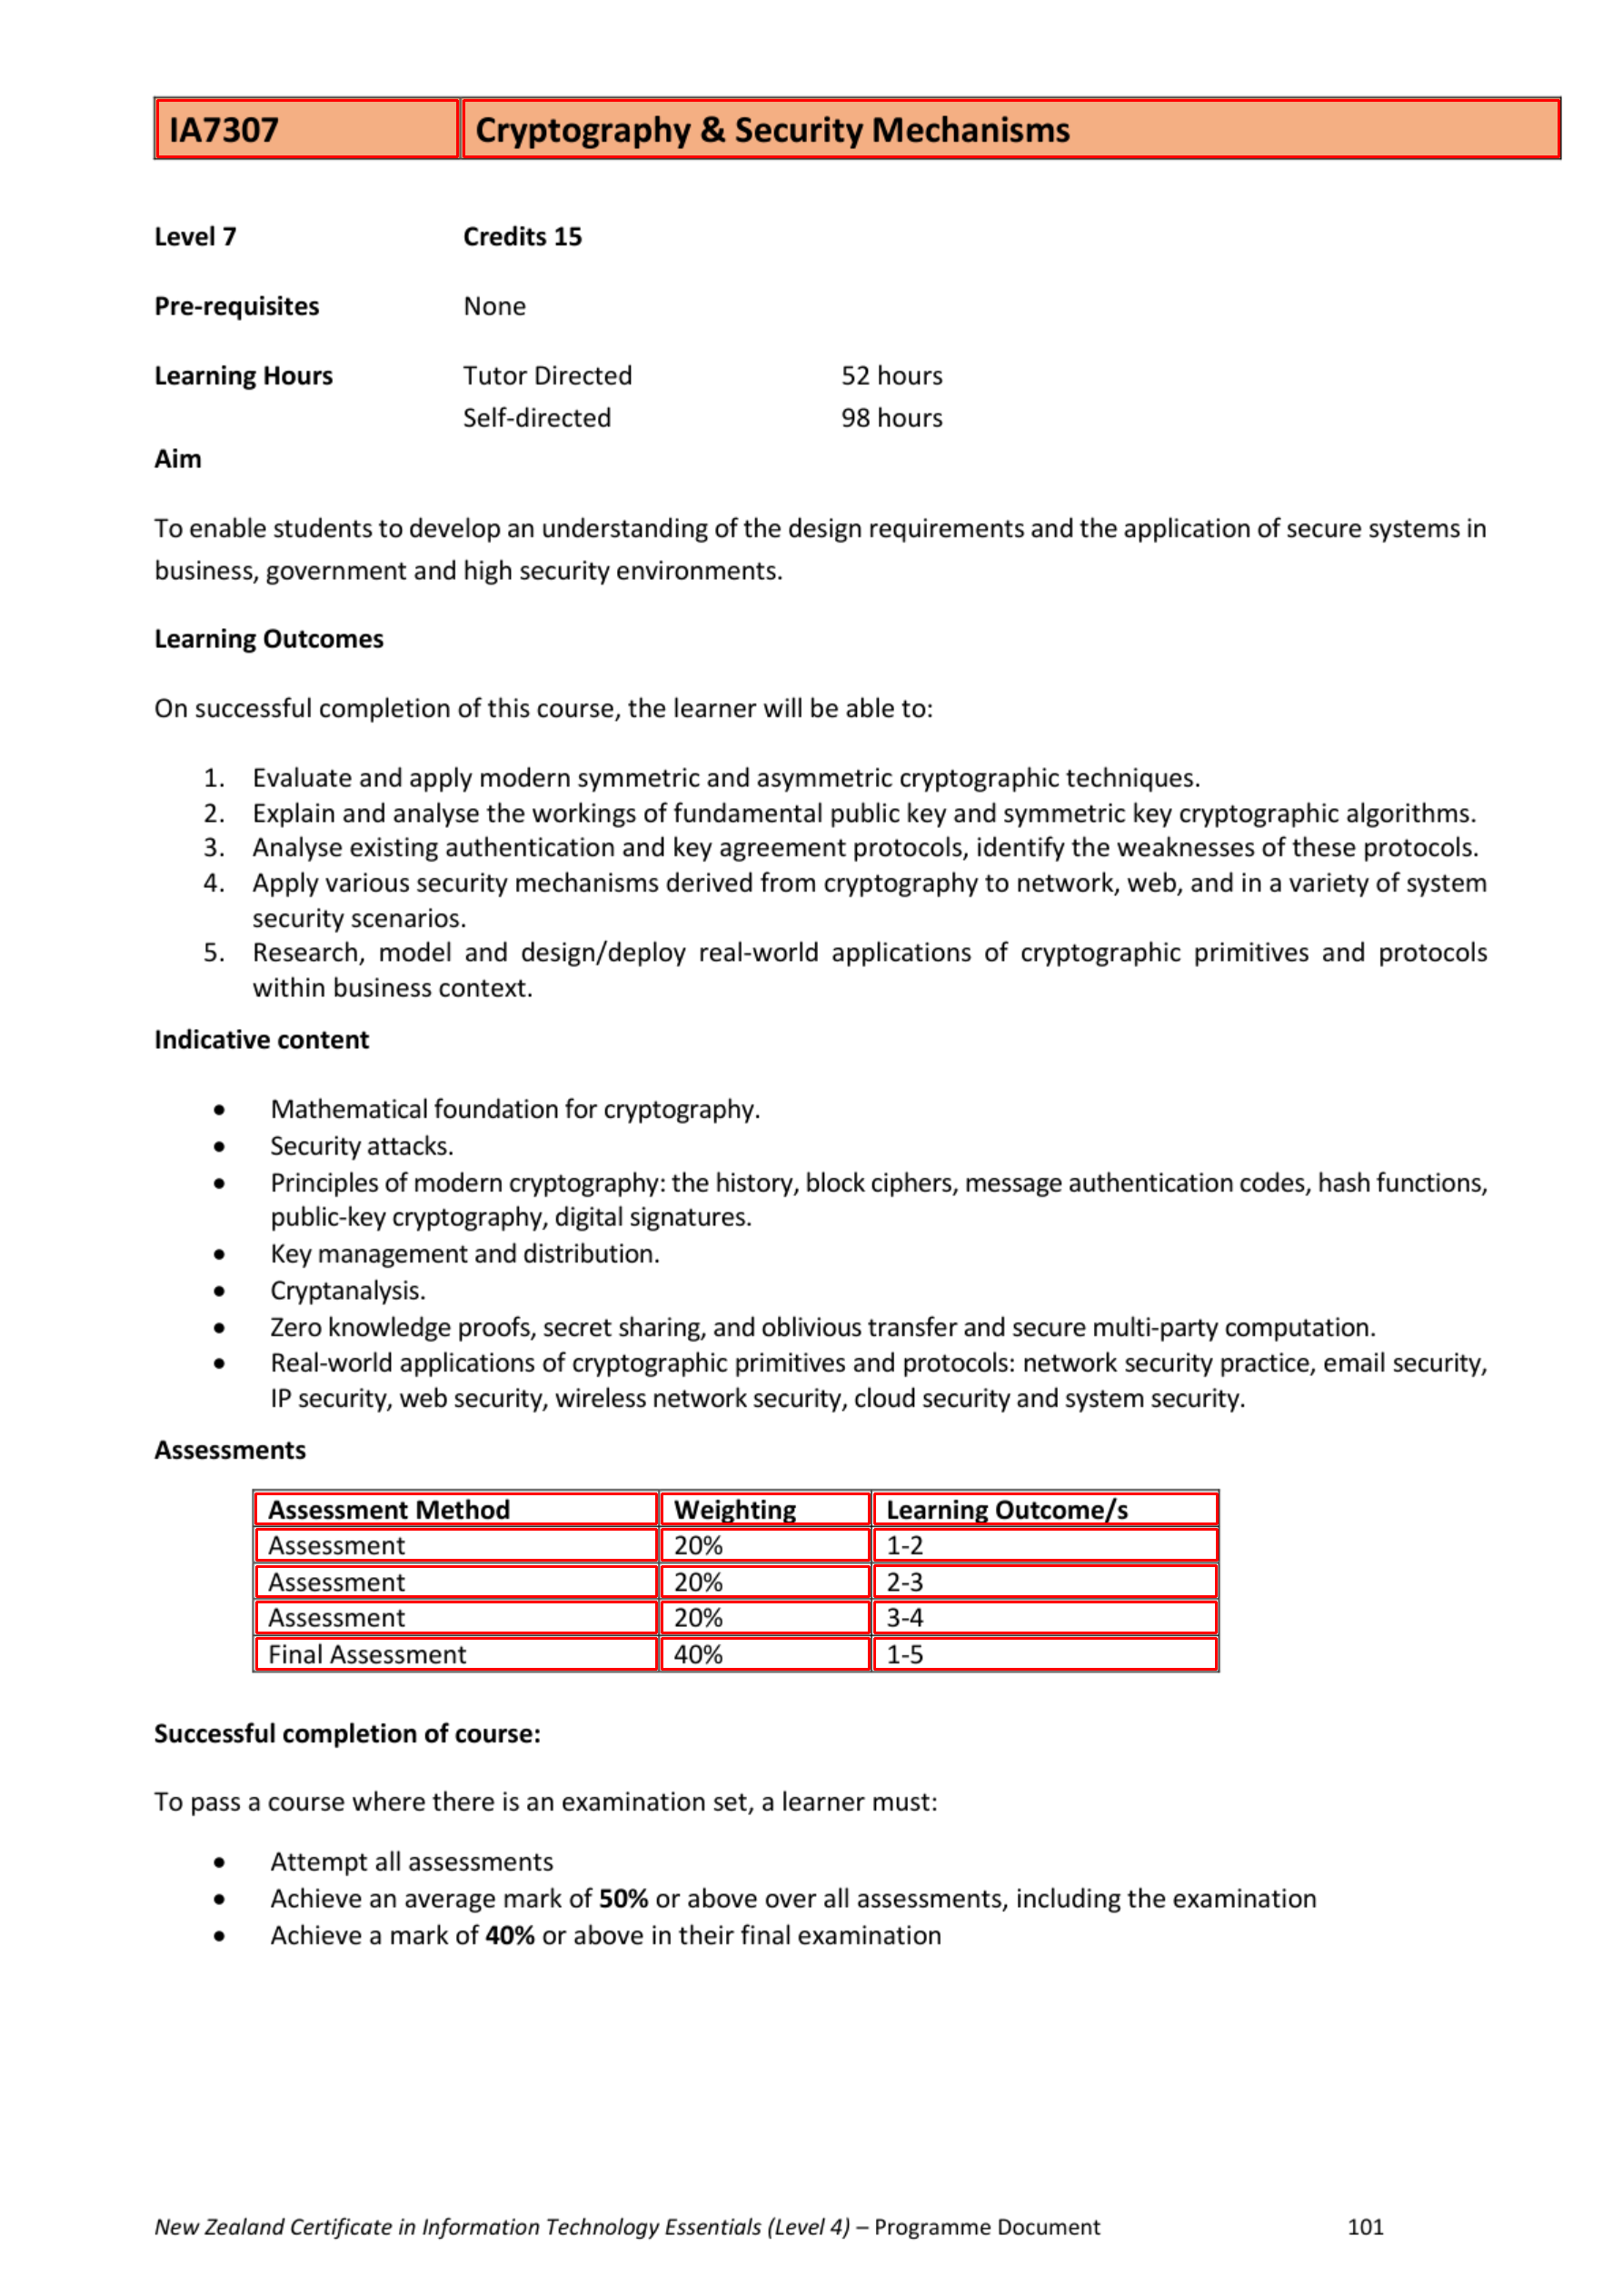

In [ ]:
cv2_imshow(tmpImageInner)

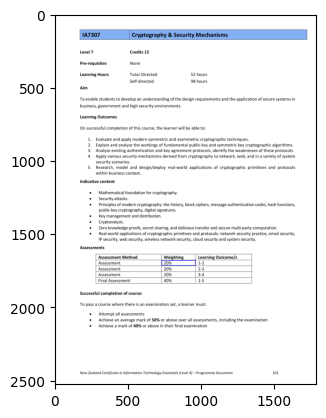

In [ ]:
tmpImageInner2 = tmpImg.copy()
# Draw child contours on the original image
#for children in child_contours:
#    for child_index in children:
child_contour = contours[12]
x, y, w, h = cv2.boundingRect(child_contour)
cv2.rectangle(tmpImageInner2, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Draw red rectangles
plt.imshow(tmpImageInner2 )

In [ ]:
# Create a blank image with the same size as the binary image
imgWithoutTables = imgBinary.copy()

In [ ]:
# Fill the regions defined by the outer rectangles with black
for rect in outer_rectangles:
    x1, y1, x2, y2 = rect
    cv2.rectangle(imgWithoutTables, (x1, y1), (x2, y2), 0, thickness=cv2.FILLED)



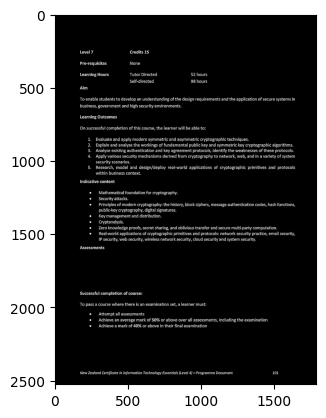

In [ ]:
plt.imshow(imgWithoutTables, cmap='gray')

In [ ]:
print(imgWithoutTables.ndim)
print(imgWithoutTables.shape)
print(type(imgWithoutTables))

2
(2526, 1786)
<class 'numpy.ndarray'>


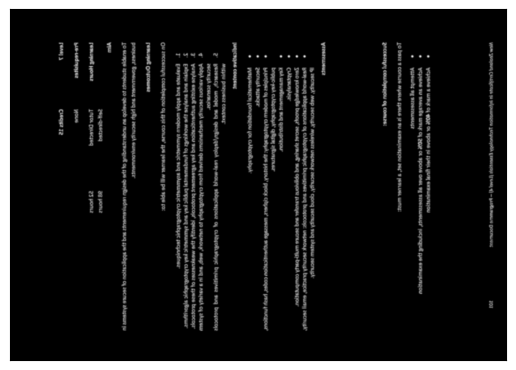

In [ ]:
imgTranspose = np.transpose(imgWithoutTables)
showImg(imgTranspose, cmap='gray')

In [ ]:
def createKernel(kernelSize, sigma, theta):
    "create anisotropic filter kernel according to given parameters"
    assert kernelSize % 2 # must be odd size
    halfSize = kernelSize // 2

    kernel = np.zeros([kernelSize, kernelSize])
    sigmaX = sigma
    sigmaY = sigma * theta

    for i in range(kernelSize):
        for j in range(kernelSize):
            x = i - halfSize
            y = j - halfSize

            expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
            xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
            yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)

            kernel[i, j] = (xTerm + yTerm) * expTerm

    kernel = kernel / np.sum(kernel)
    return kernel

In [ ]:
kernelSize=9
sigma=4
theta=1.5
#25, 0.8, 3.5

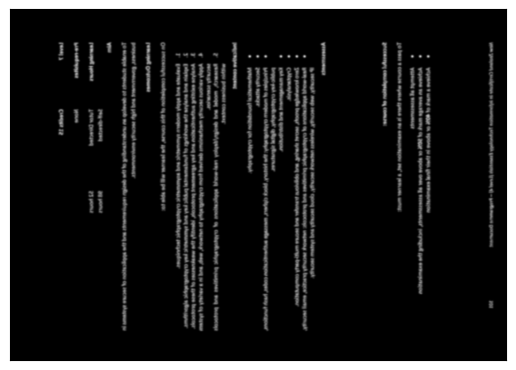

In [ ]:
imgFiltered1 = cv2.filter2D(imgTranspose, -1, createKernel(kernelSize, sigma, theta), borderType=cv2.BORDER_REPLICATE)
showImg(imgFiltered1, cmap='gray')

In [ ]:
def applySummFunctin(img):
    res = np.sum(img, axis = 0)    #  summ elements in columns
    return res

In [ ]:
def normalize(img):
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    return img
img4 = normalize(imgFiltered1)

In [ ]:
(m, s) = cv2.meanStdDev(imgFiltered1)
m[0][0]

9.310139286932277

In [ ]:
summ = applySummFunctin(img4)
print(summ.ndim)
print(summ.shape)

1
(1684,)


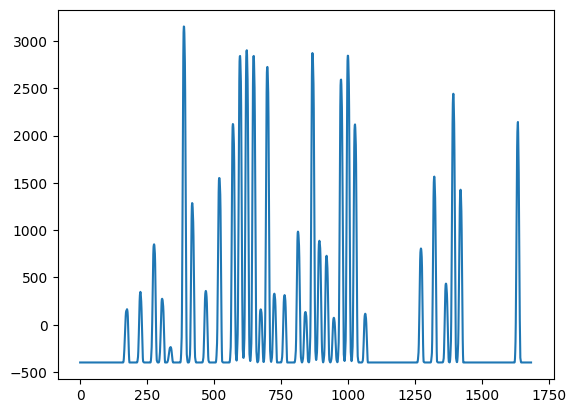

In [ ]:
plt.plot(summ)
plt.show()

In [ ]:
def smooth(x, window_len=11, window='hanning'):
#     if x.ndim != 1:
#         raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y

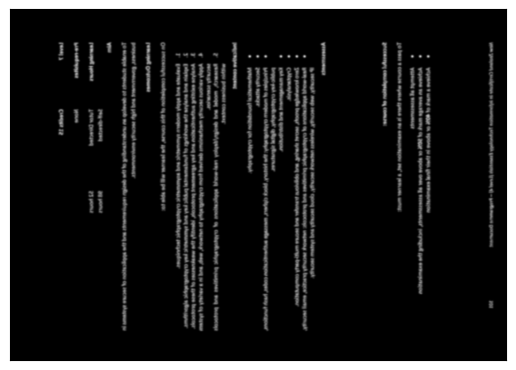

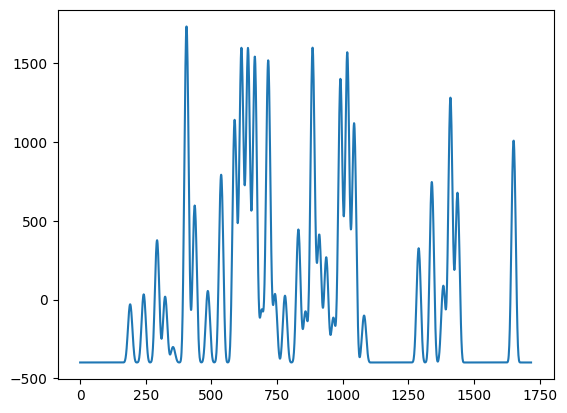

In [ ]:
windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
smoothed = smooth(summ, 35)
showImg(imgFiltered1, cmap='gray')
plt.plot(smoothed)
plt.show()

In [ ]:
from scipy.signal import argrelmin
#mins = argrelmin(smoothed, order=2)
mins = argrelmin(summ, order=2)
arr_mins = np.array(mins)

In [ ]:
arr_mins

array([[ 584,  610,  635,  662,  685,  713,  828,  854,  881,  907,  934,
         960,  987, 1013, 1379, 1406]])

In [ ]:
smoothed

array([-399.35566884, -399.35566884, -399.35566884, ..., -399.35566884,
       -399.35566884, -399.35566884])

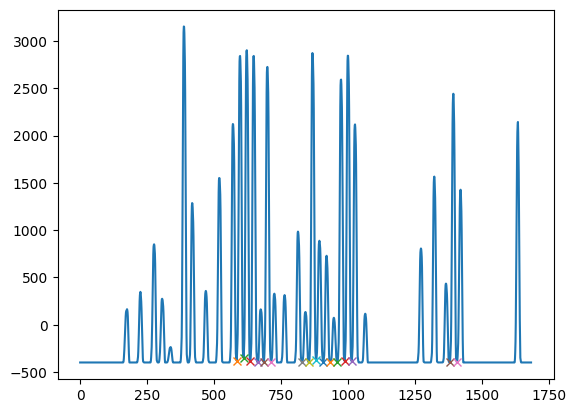

In [ ]:
plt.plot(summ)
plt.plot(arr_mins, summ[arr_mins], "x")
plt.show()

In [ ]:
def crop_text_to_lines(text, blanks):
    x1 = 0
    y = 0
    lines = []
    for i, blank in enumerate(blanks):
        x2 = blank
        print("x1=", x1, ", x2=", x2, ", Diff= ", x2-x1)
        line = text[:, x1:x2]
        lines.append(line)
        x1 = blank
    return lines

In [ ]:
def display_lines(lines_arr, orient='vertical'):
    plt.figure(figsize=(30, 30))
    if not orient in ['vertical', 'horizontal']:
        raise ValueError("Orientation is on of 'vertical', 'horizontal', defaul = 'vertical'")
    if orient == 'vertical':
        for i, l in enumerate(lines_arr):
            line = l
            plt.subplot(2, 10, i+1)  # A grid of 2 rows x 10 columns
            plt.axis('off')
            plt.title("Line #{0}".format(i))
            _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    else:
            for i, l in enumerate(lines_arr):
                line = l
                plt.subplot(40, 1, i+1)  # A grid of 40 rows x 1 columns
                plt.axis('off')
                plt.title("Line #{0}".format(i))
                _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
                plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [ ]:
found_lines = crop_text_to_lines(imgTranspose, arr_mins[0])

x1= 0 , x2= 584 , Diff=  584
x1= 584 , x2= 610 , Diff=  26
x1= 610 , x2= 635 , Diff=  25
x1= 635 , x2= 662 , Diff=  27
x1= 662 , x2= 685 , Diff=  23
x1= 685 , x2= 713 , Diff=  28
x1= 713 , x2= 828 , Diff=  115
x1= 828 , x2= 854 , Diff=  26
x1= 854 , x2= 881 , Diff=  27
x1= 881 , x2= 907 , Diff=  26
x1= 907 , x2= 934 , Diff=  27
x1= 934 , x2= 960 , Diff=  26
x1= 960 , x2= 987 , Diff=  27
x1= 987 , x2= 1013 , Diff=  26
x1= 1013 , x2= 1379 , Diff=  366
x1= 1379 , x2= 1406 , Diff=  27


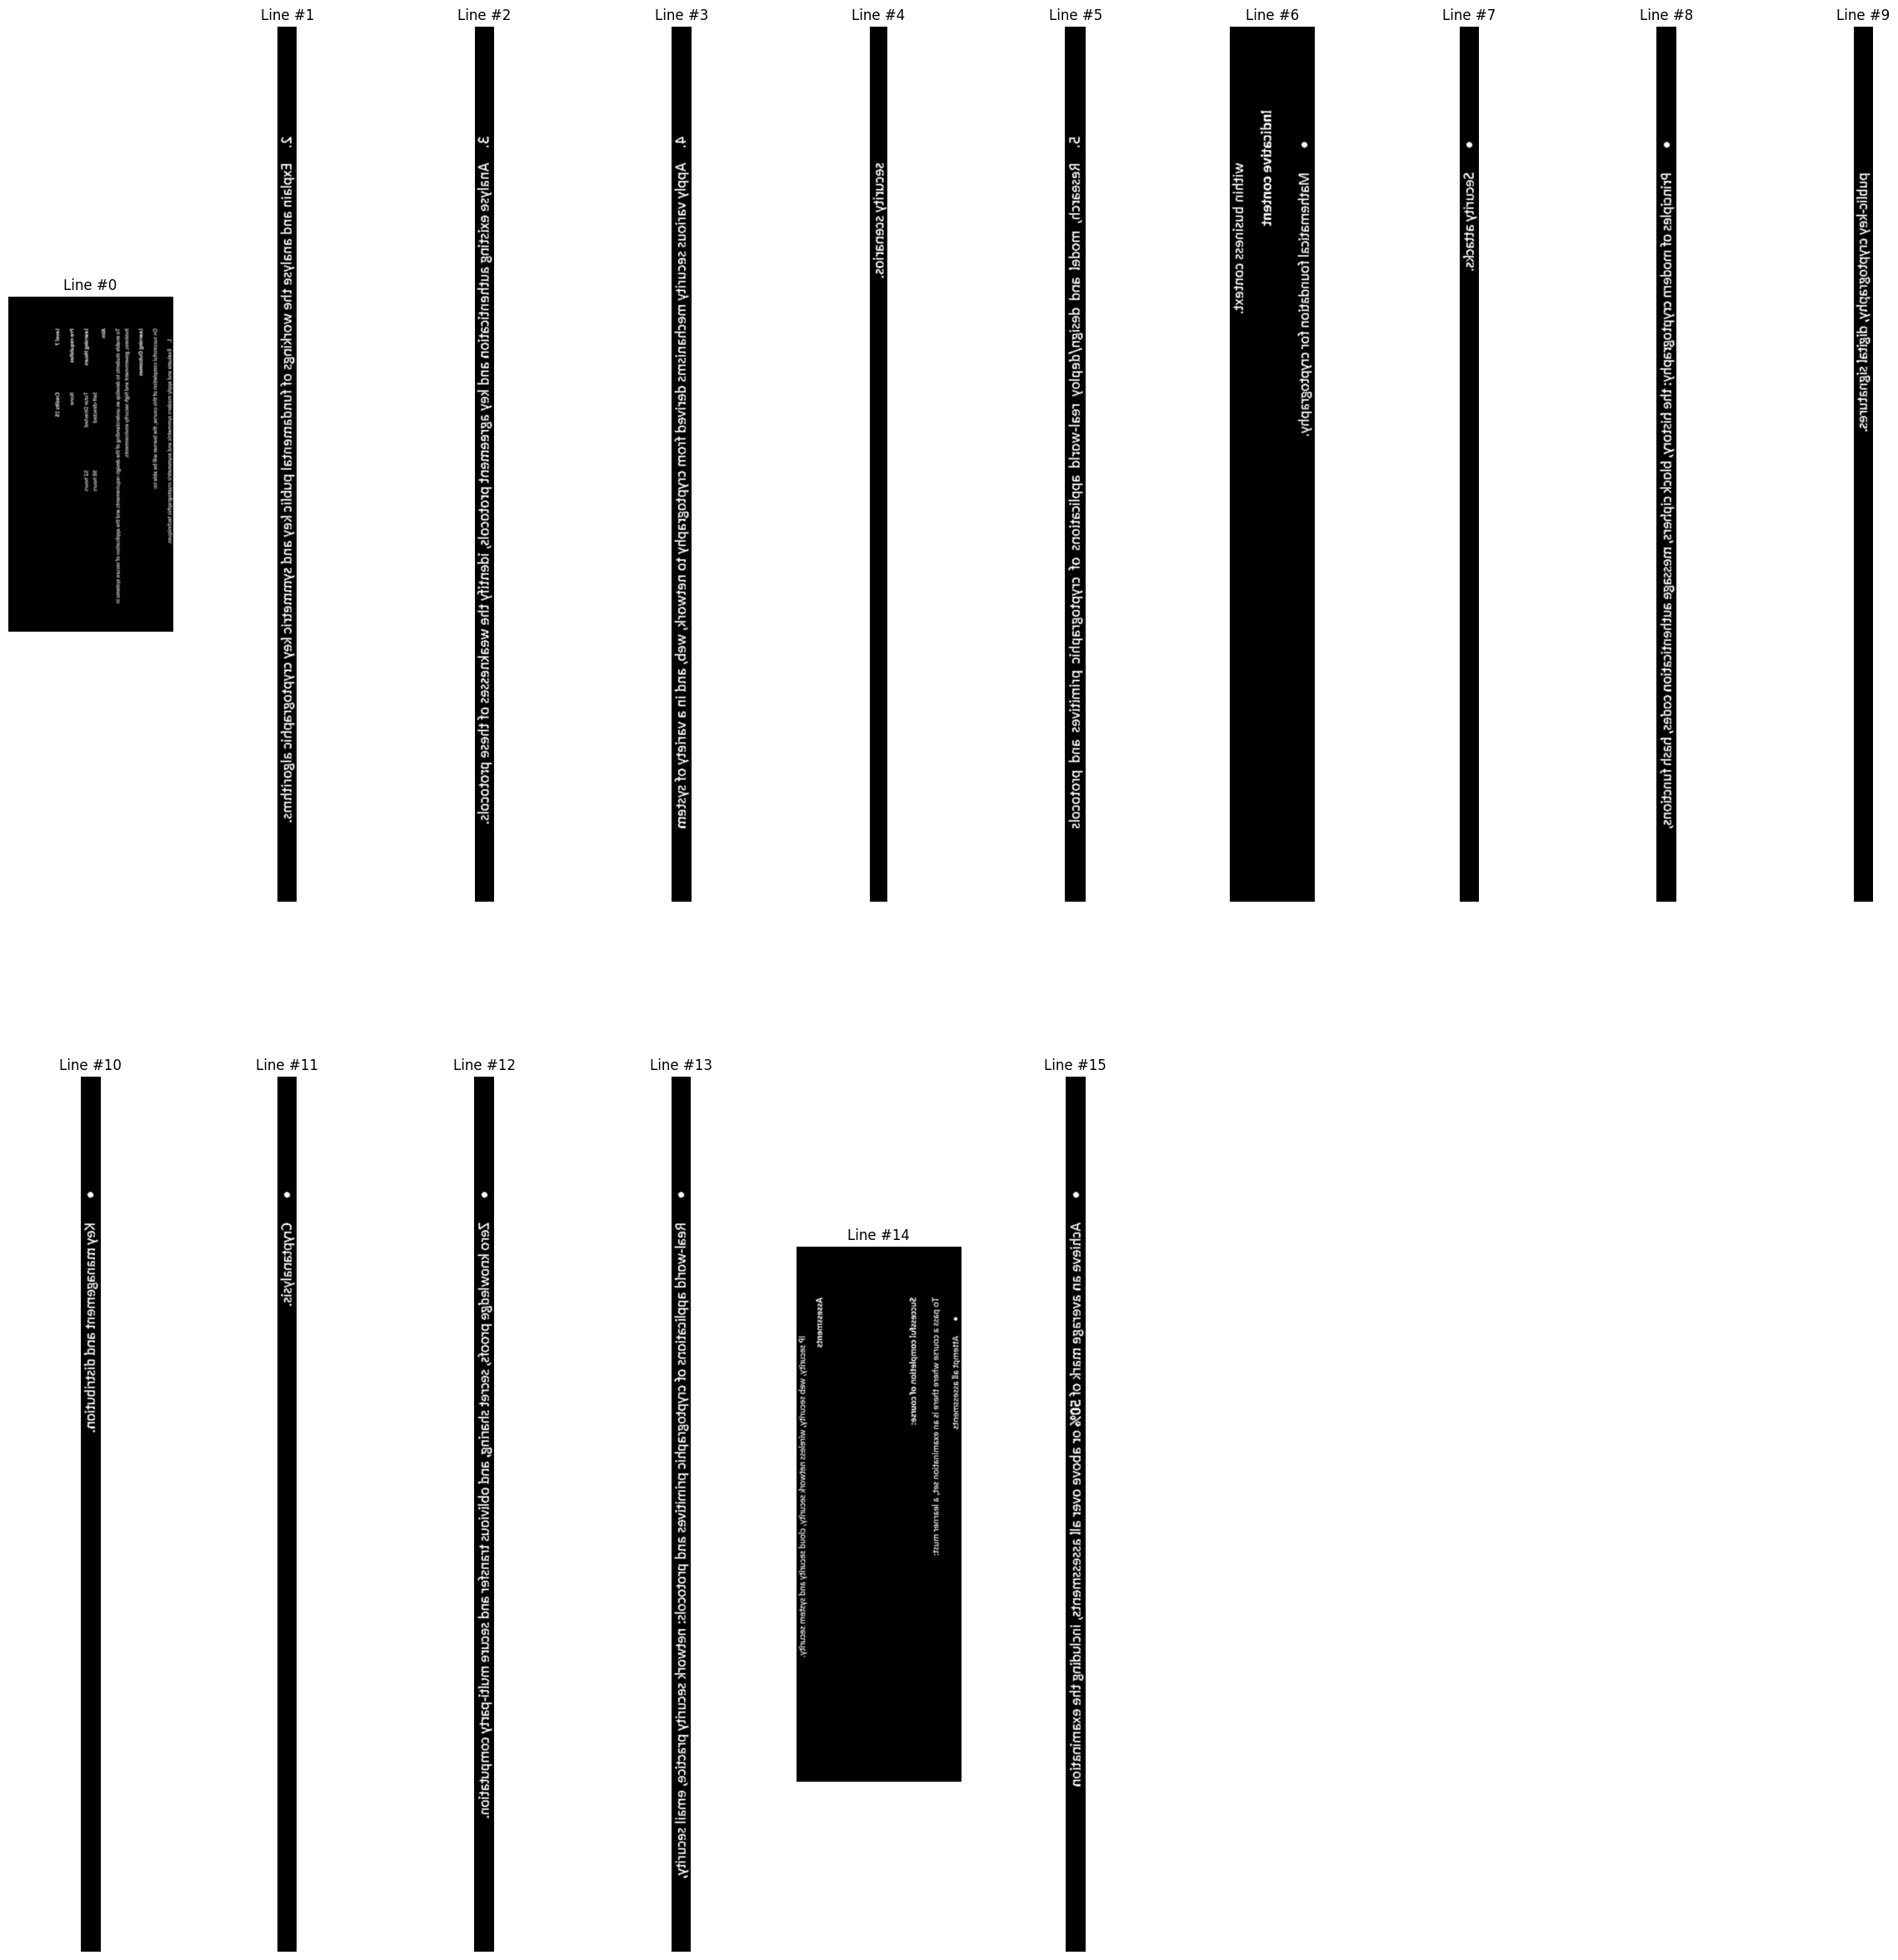

In [ ]:
display_lines(found_lines)

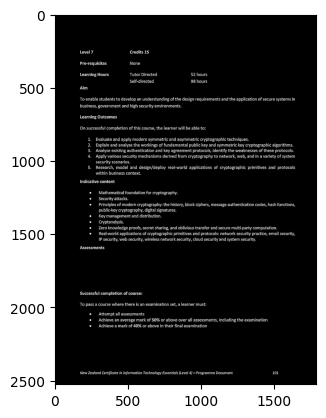

In [ ]:
plt.imshow(imgWithoutTables, cmap='gray')

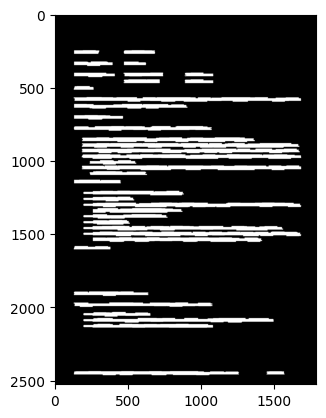

In [ ]:
#dilation
kernel = np.ones((4,85), np.uint8)
dilated = cv2.dilate(imgWithoutTables, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray');

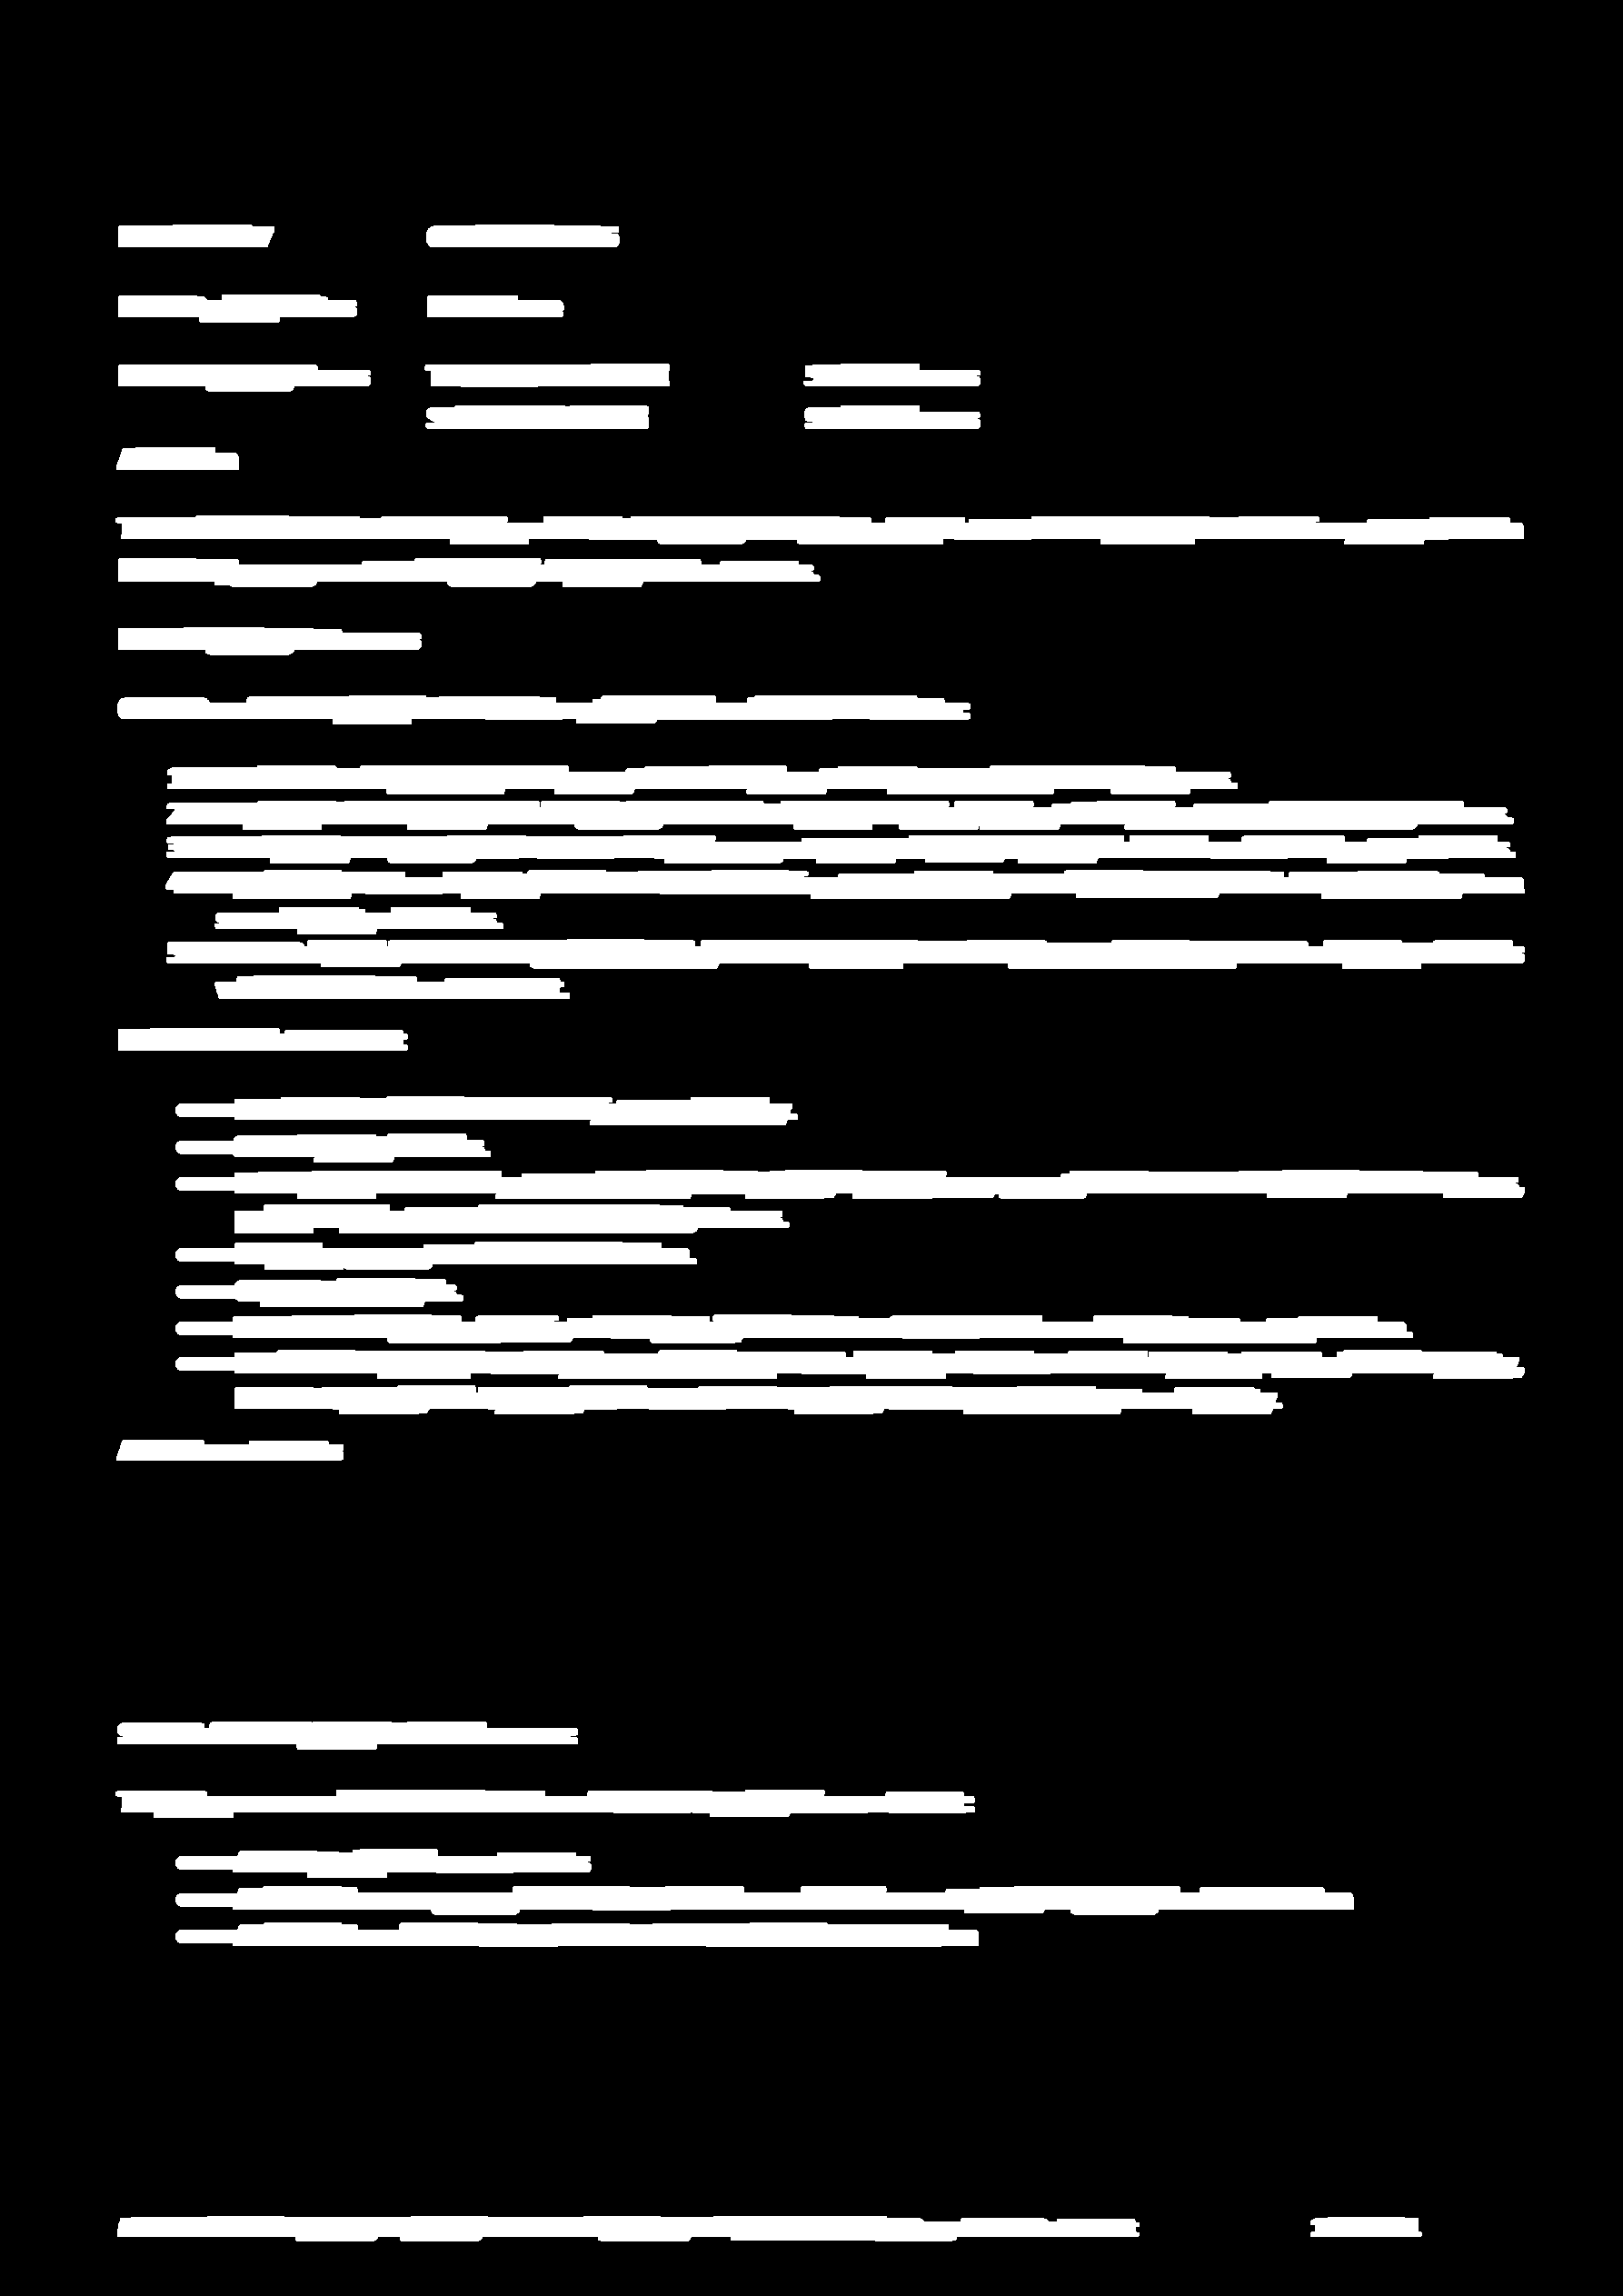

In [ ]:
cv2_imshow(dilated)

In [ ]:
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)

## Line segmentation

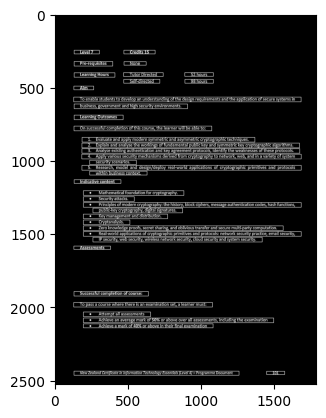

In [ ]:
img2 = imgWithoutTables.copy()

for ctr in sorted_contours_lines:

    x,y,w,h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x,y), (x+w, y+h), (255, 255, 255), 2)

plt.imshow(img2, 'gray');

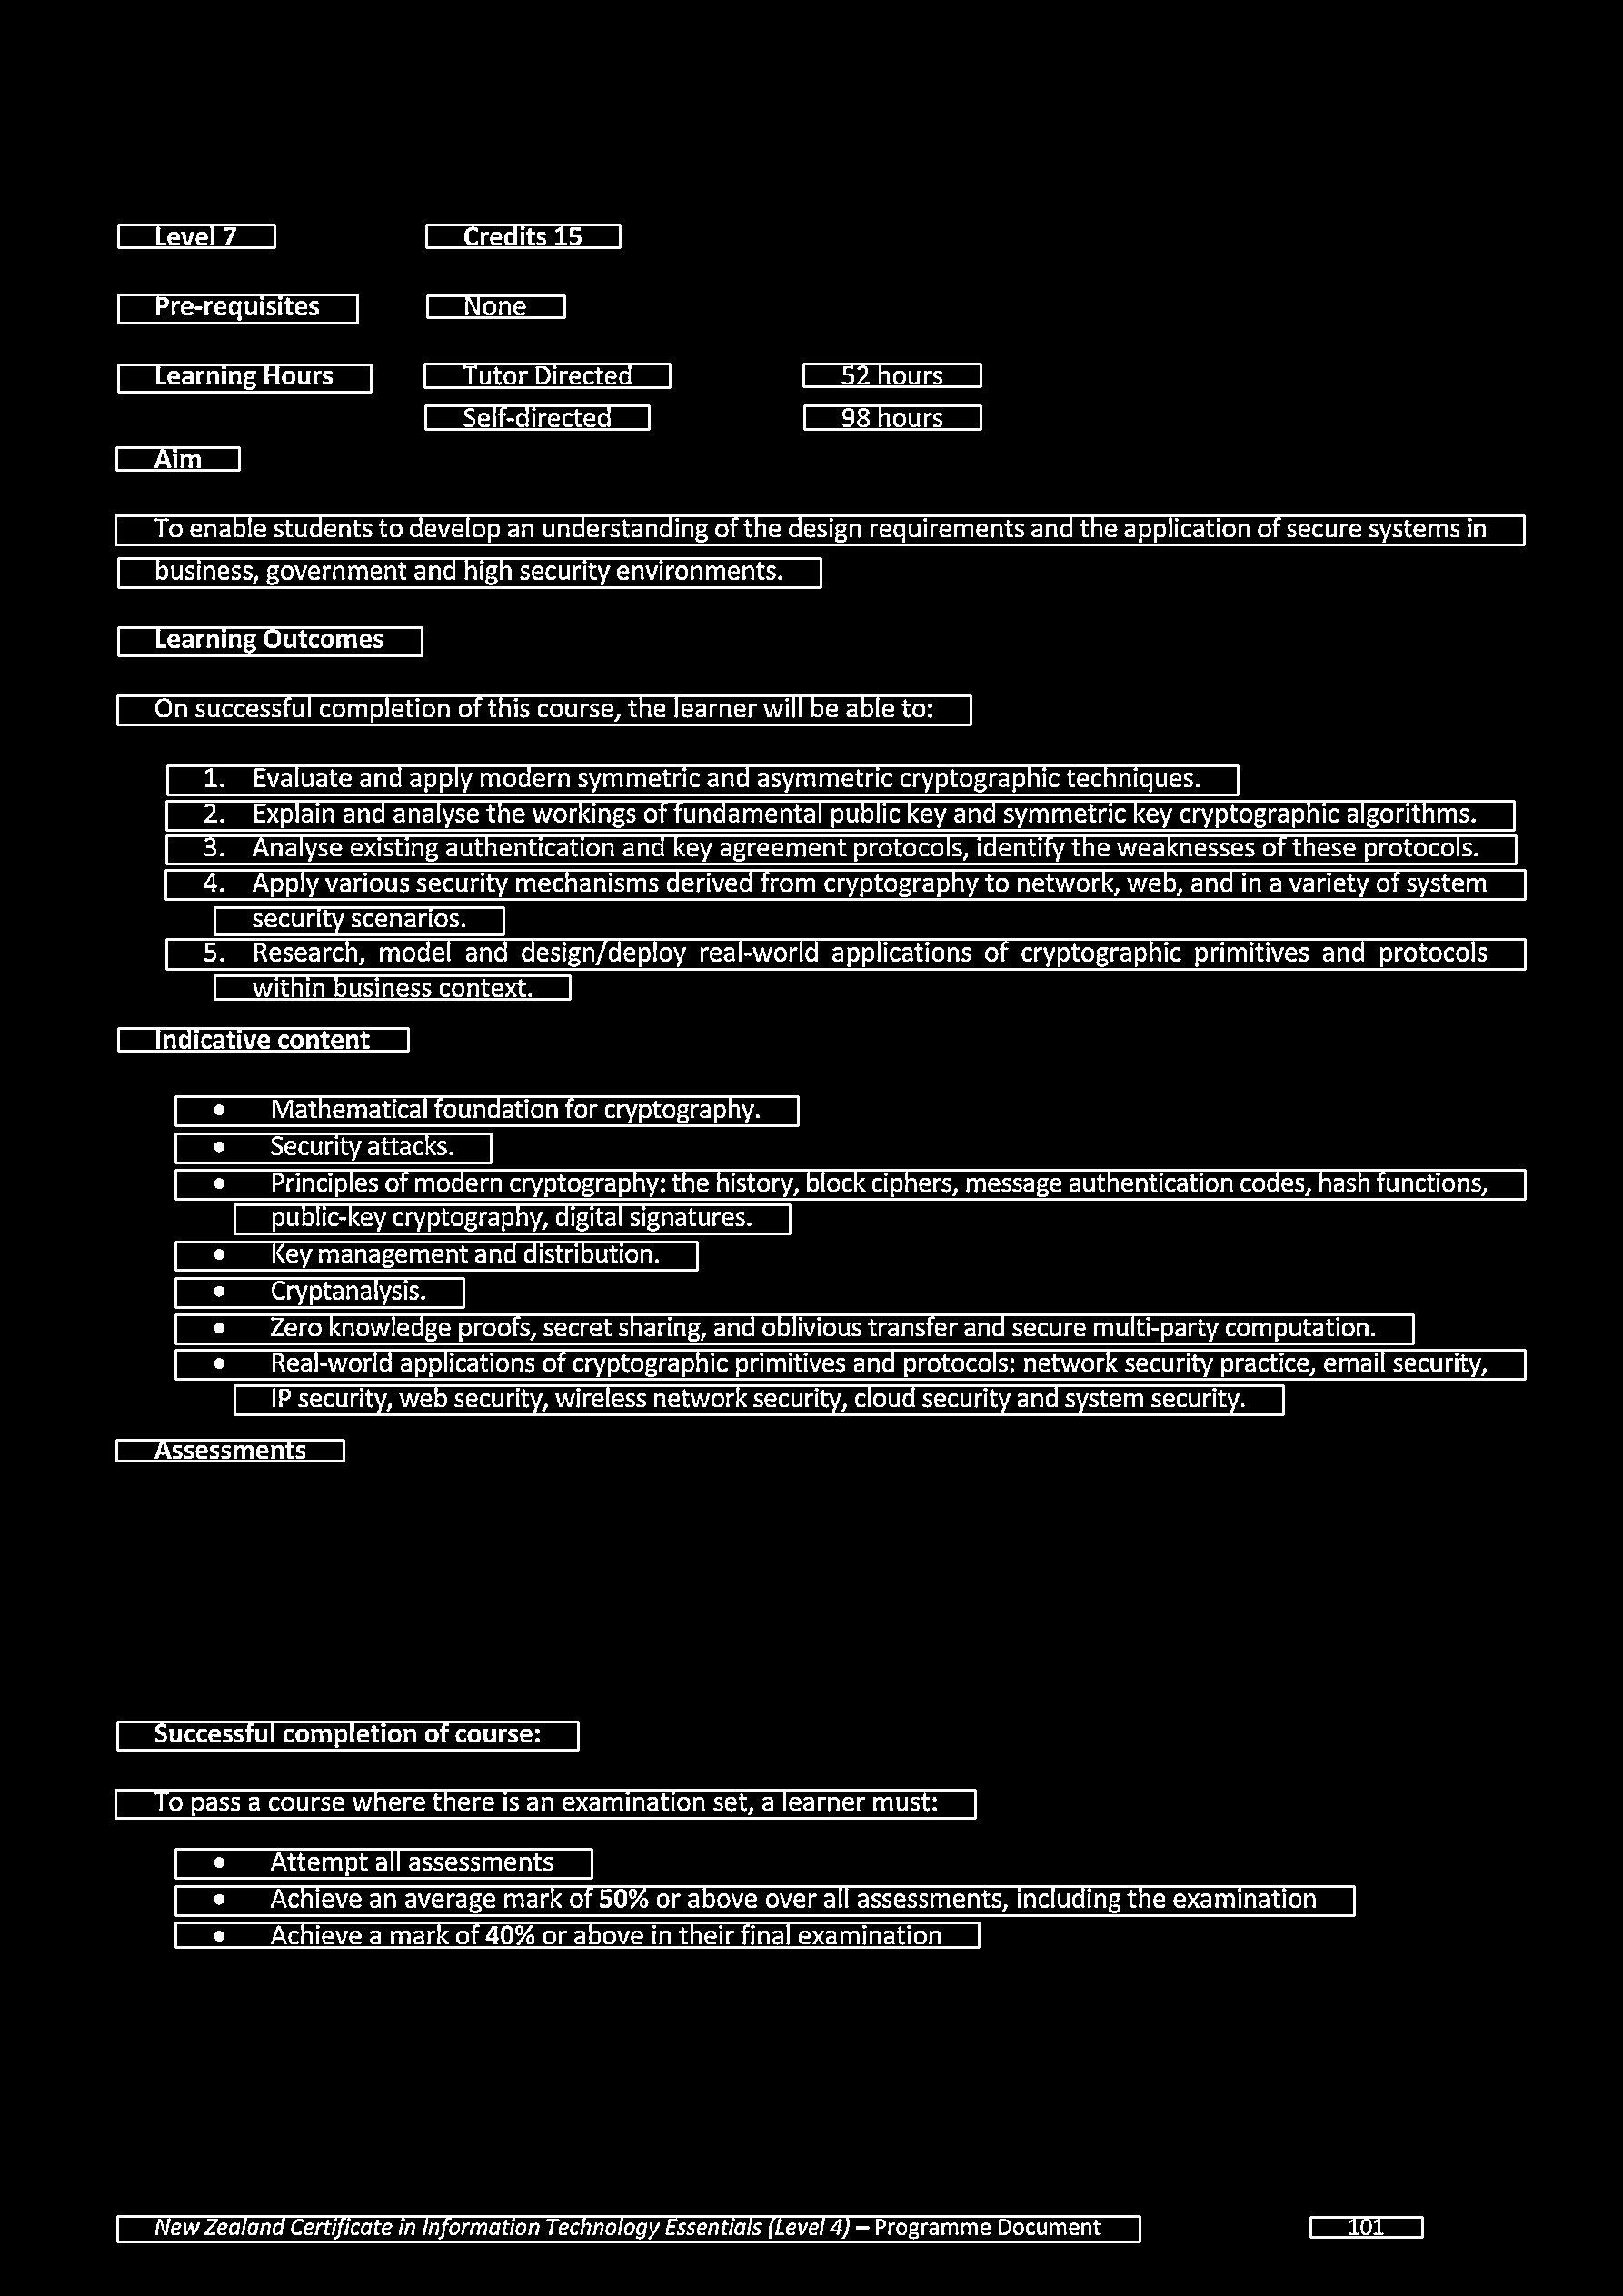

In [ ]:
cv2_imshow(img2)

# Text segmentation

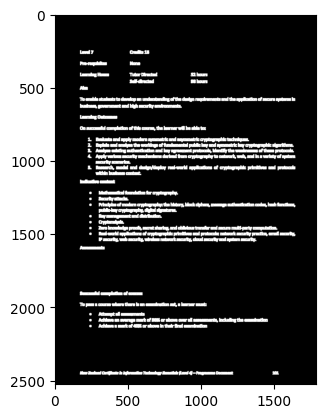

In [ ]:
#dilation
kernel = np.ones((6,6), np.uint8)
dilated2 = cv2.dilate(imgWithoutTables, kernel, iterations = 1)
plt.imshow(dilated2, cmap='gray');

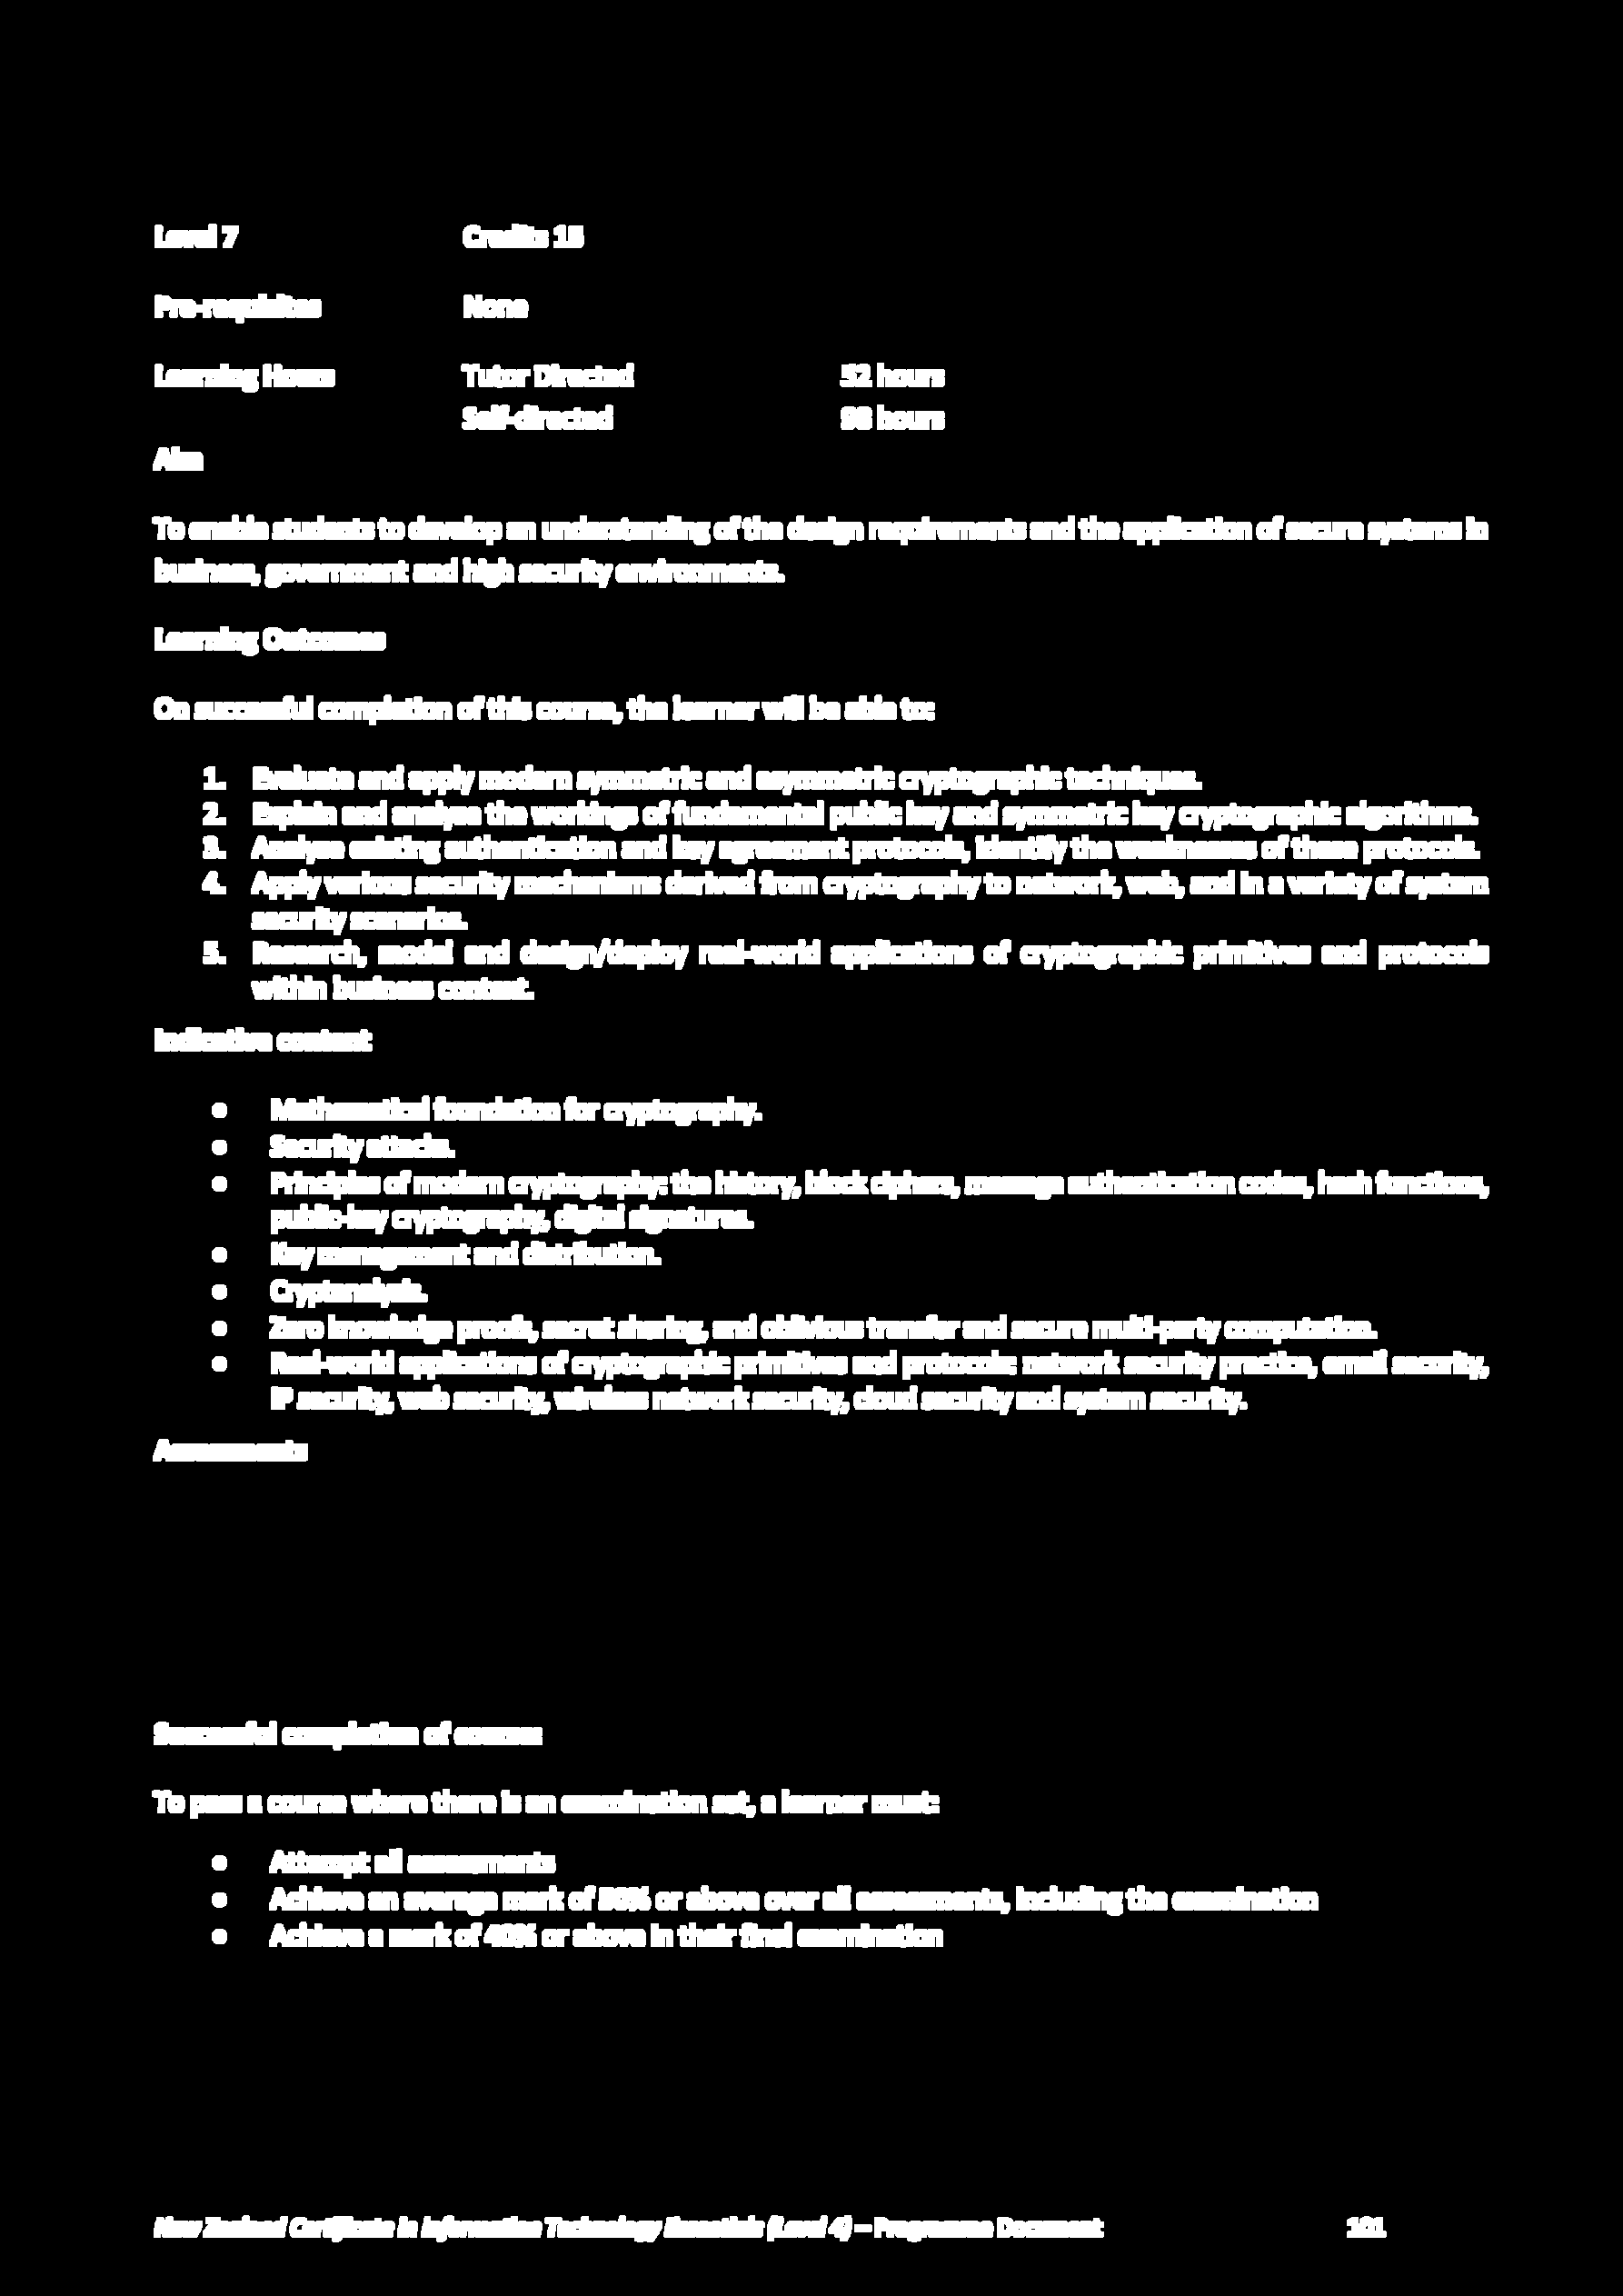

In [ ]:
cv2_imshow(dilated2)

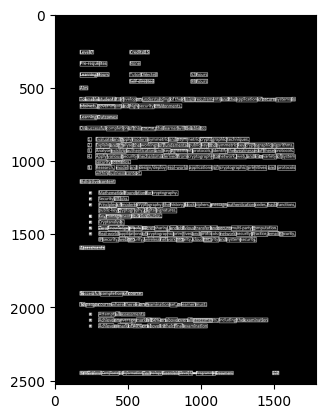

In [ ]:
img3 = imgWithoutTables.copy()
words_list = []

for line in sorted_contours_lines:

    # roi of each line
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y+w, x:x+w]

    # draw contours on each word
    (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])

    for word in sorted_contour_words:

        #if cv2.contourArea(word) < 400:
        #    continue

        x2, y2, w2, h2 = cv2.boundingRect(word)
        words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
        cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (255,255,100),2)

plt.imshow(img3, 'gray');

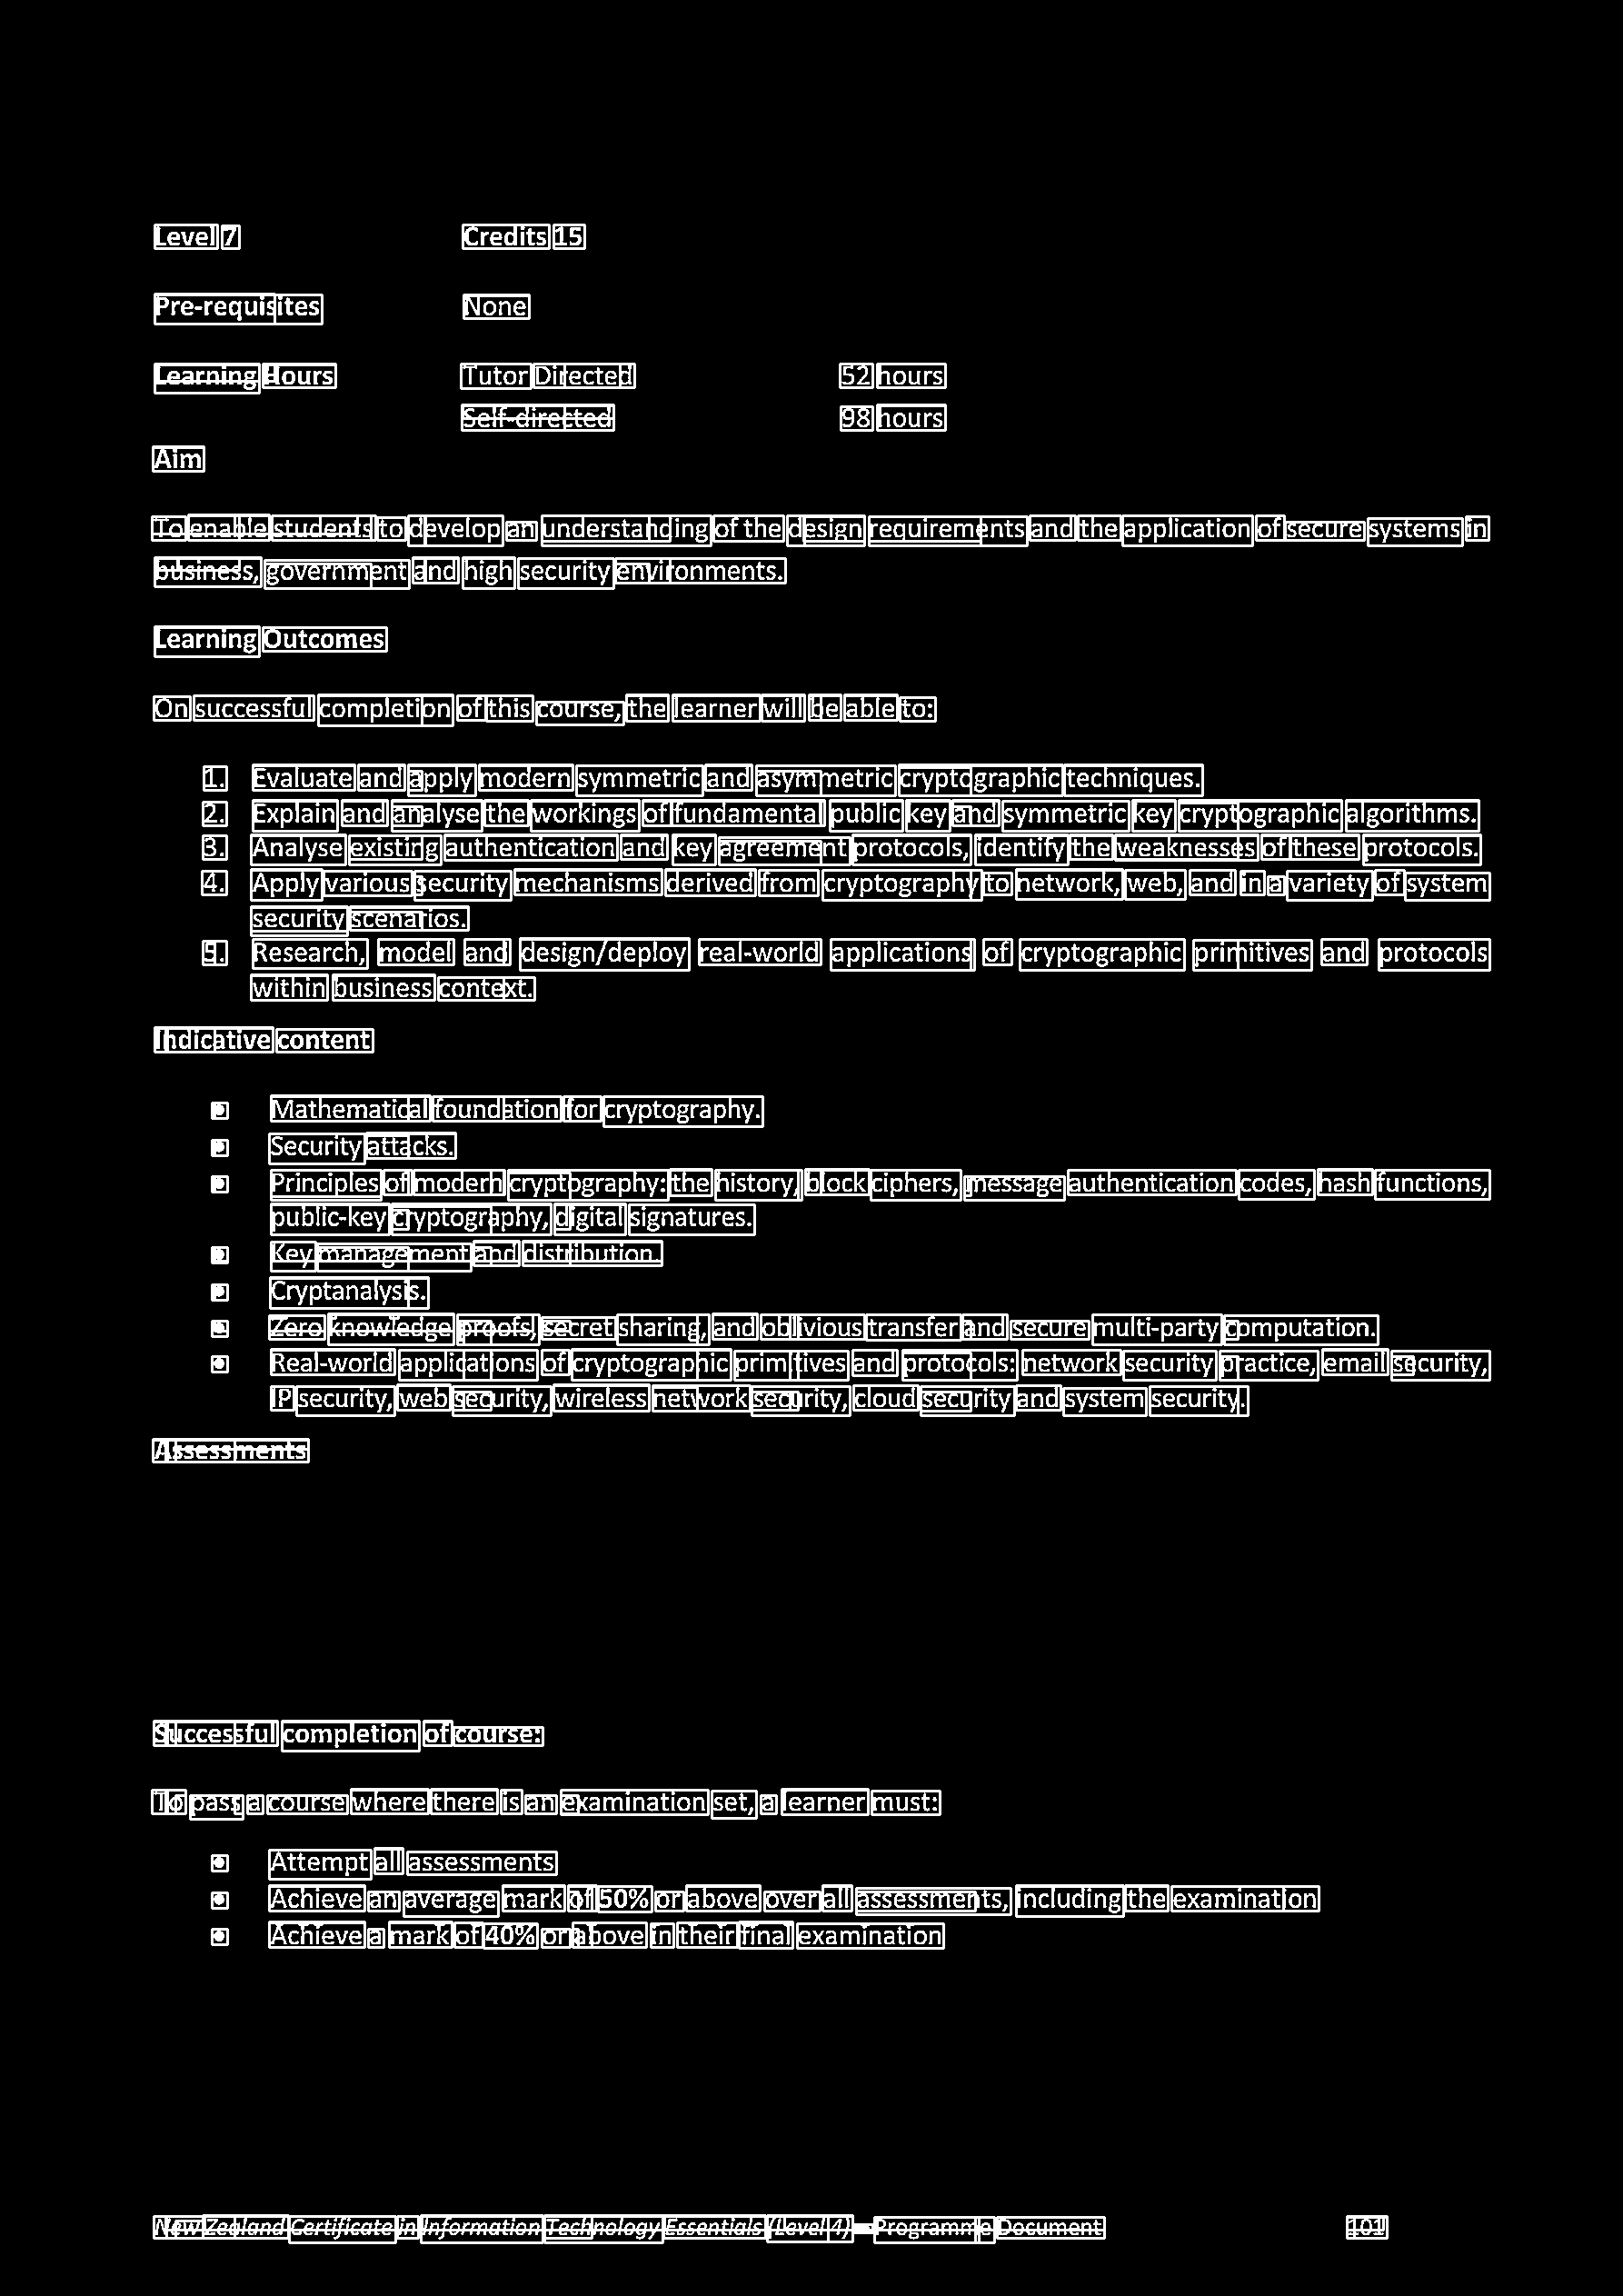

In [ ]:
#plt.figure(figsize=(20,15))
#plt.subplot(1,2,1),plt.imshow(img3, cmap = 'gray')
cv2_imshow(img3)

In [ ]:
# Sort the coordinates based on x, then y
words_list = sorted(words_list, key=lambda coord: (coord[1]//20, coord[0]))

In [ ]:
def calculate_area(coord):
    # Calculate the area of a rectangle defined by [x, y, w, h]
    return coord[2] * coord[3]

def is_overlapping(coord1, coord2):
    buffer = 20
    # Check if two rectangles defined by [x, y, w, h] are overlapping
    x1, y1, w1, h1 = coord1
    x2, y2, w2, h2 = coord2
    #return (x1 < x2 + w2 and x1 + w1 > x2 and y1 < y2 + h2 and y1 + h1 > y2)
    return ((x1 - buffer <= x2 <= x1 + w1 + buffer and x1 - buffer <= x2 + w2 <= x1 + w1 + buffer
             and y1 - buffer <= y2 <= y1 + h1 + buffer and y1 - buffer <= y2 + h2 <= y1 + h1 +buffer)
          or (x2 - buffer <= x1 <= x2 + w2 + buffer and x2 - buffer <= x1 + w1 <= x2 + w2 + buffer
              and y2 - buffer <= y1 <= y2 + h2 + buffer and y2 - buffer <= y1 + h1 <= y2 + h2 + buffer))

def remove_overlapping(rectangles):
    # Sort the rectangles by area (largest first)
    rectangles.sort(key=calculate_area, reverse=True)

    # Initialize a list to store non-overlapping rectangles
    non_overlapping_rectangles = []

    for rect in rectangles:
        if all(not is_overlapping(rect, existing_rect) for existing_rect in non_overlapping_rectangles):
            non_overlapping_rectangles.append(rect)

    return non_overlapping_rectangles

# take second element for sort
def takeFirst(elem):
    return elem[0]

def is_overlapping_characters(coord1, coord2):
    buffer = 0
    # Check if two rectangles defined by [x, y, w, h] are overlapping
    x11, x12 = coord1
    x21, x22 = coord2

    return (( x11 - buffer <= x21 <= x11 + buffer and x12 - buffer <= x22 <= x12 + buffer)
             or (x21 - buffer <= x11 <= x21 + buffer and x22 - buffer <= x12 <= x22 + buffer))

def remove_overlapping_characters(x_coor):
  x_coor.sort(key=takeFirst)

  # Initialize a list to store non-overlapping rectangles
  non_overlapping_characters = []

  for char in x_coor:
    if all(not is_overlapping_characters(char, existing_char) for existing_char in non_overlapping_characters):
            non_overlapping_characters.append(char)


  return non_overlapping_characters


In [ ]:
# Remove overlapping rectangles
non_overlapping_coordinates = remove_overlapping(words_list)

In [ ]:
len(non_overlapping_coordinates)

272

In [ ]:
# Sort the coordinates based on x, then y
non_overlapping_coordinates = sorted(non_overlapping_coordinates, key=lambda coord: (coord[1]//10, coord[0]))

In [ ]:
non_overlapping_coordinates[0:35]

[[170, 247, 239, 273],
 [244, 248, 263, 273],
 [509, 247, 604, 273],
 [609, 247, 643, 273],
 [170, 324, 354, 356],
 [510, 324, 582, 350],
 [170, 400, 285, 432],
 [289, 400, 369, 426],
 [507, 400, 584, 427],
 [587, 400, 698, 426],
 [924, 400, 960, 426],
 [965, 400, 1040, 426],
 [508, 445, 675, 473],
 [925, 447, 960, 473],
 [965, 445, 1040, 473],
 [168, 491, 224, 518],
 [167, 568, 204, 594],
 [207, 566, 296, 594],
 [299, 567, 413, 594],
 [415, 569, 446, 594],
 [449, 567, 553, 600],
 [596, 567, 782, 600],
 [785, 567, 862, 595],
 [866, 567, 951, 600],
 [956, 568, 1130, 600],
 [1133, 567, 1183, 594],
 [1186, 567, 1233, 594],
 [1235, 567, 1378, 600],
 [1382, 567, 1413, 594],
 [1613, 568, 1638, 594],
 [557, 574, 590, 594],
 [1414, 574, 1501, 594],
 [1505, 570, 1609, 600],
 [170, 613, 287, 645],
 [291, 616, 450, 647]]

In [ ]:
is_overlapping(non_overlapping_coordinates[60],non_overlapping_coordinates[61])

False

In [ ]:
tmpOver = remove_overlapping(non_overlapping_coordinates[123:125])

In [ ]:
tmpOver

[[1012, 689, 1093, 711], [149, 690, 166, 707]]

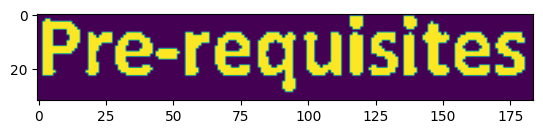

In [ ]:
ninth_word = non_overlapping_coordinates[4]
roi_9 = imgWithoutTables[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
plt.imshow(roi_9);

(<Axes: >, <matplotlib.image.AxesImage at 0x799cba9ee3b0>)

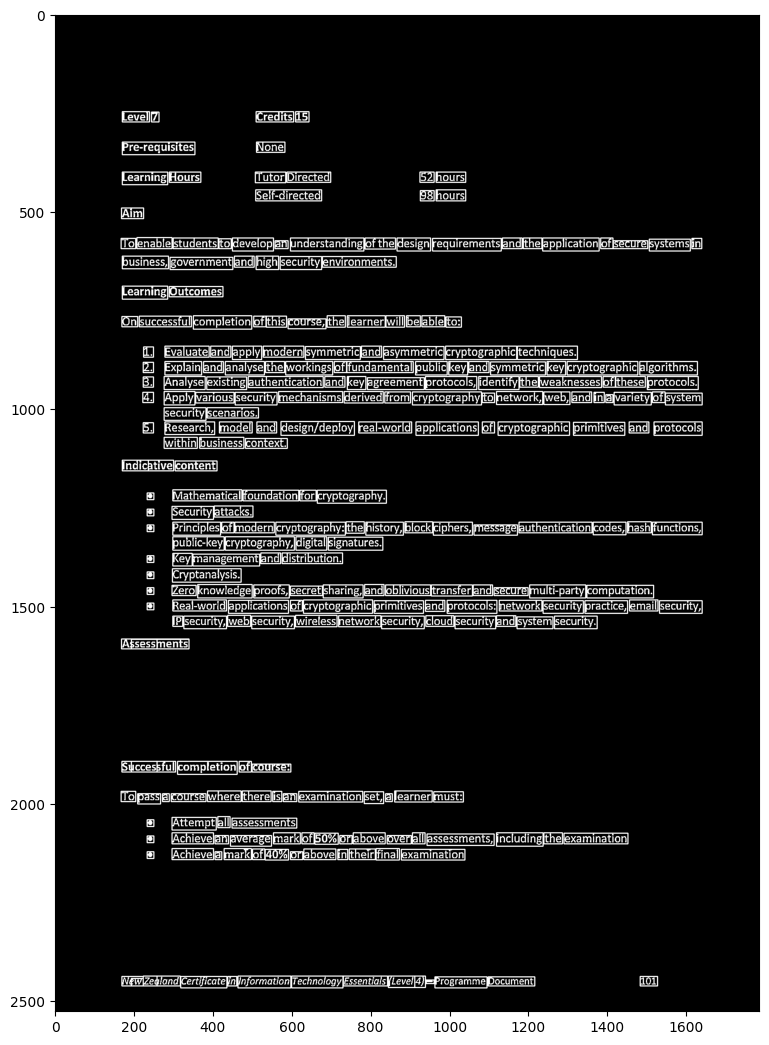

In [ ]:
img4 = imgWithoutTables.copy()
for word in non_overlapping_coordinates:
  cv2.rectangle(img4, (word[0], word[1]), (word[2], word[3]), (255,255,100),2)

plt.figure(figsize=(20,15))
plt.subplot(1,2,1),plt.imshow(img4, cmap = 'gray')

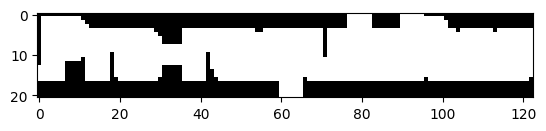

In [ ]:
kernel = np.ones((4,4), np.uint8)
dilated33 = cv2.dilate(roi_9, kernel, iterations = 1)
plt.imshow(dilated33, cmap='gray');

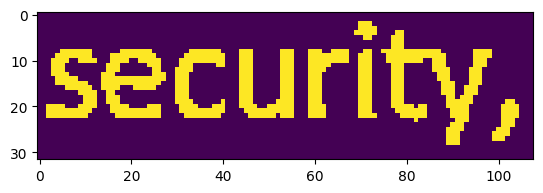

In [ ]:
ninth_word = non_overlapping_coordinates[60]
roi_9 = imgWithoutTables[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
plt.imshow(roi_9);

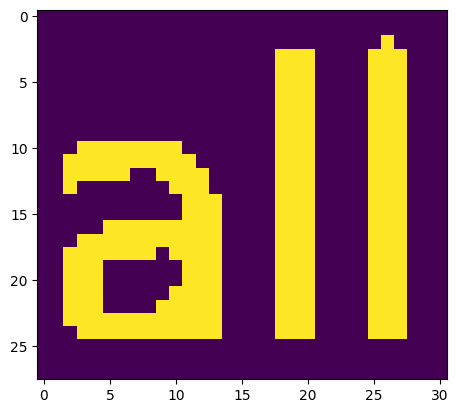

In [ ]:
ninth_word = non_overlapping_coordinates[125]
roi_9 = imgWithoutTables[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
plt.imshow(roi_9);

In [ ]:
len(words_list)

1818

In [ ]:
words_list[0:5]

[[112, 164, 159, 181],
 [162, 165, 175, 181],
 [339, 164, 403, 181],
 [405, 165, 429, 181],
 [112, 216, 236, 236]]

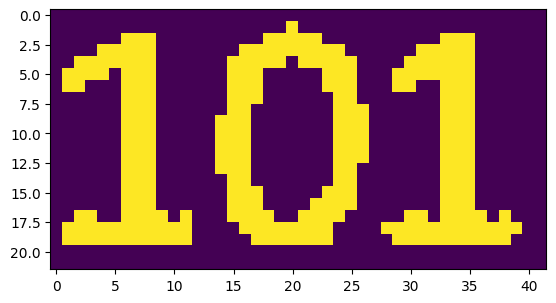

In [ ]:
ninth_word = words_list[2]
roi_9 = imgWithoutTables[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
plt.imshow(roi_9);

In [ ]:
words_list[2200: 2220]

[[641, 1626, 729, 1643],
 [731, 1626, 810, 1631],
 [731, 1626, 810, 1640],
 [731, 1626, 810, 1640],
 [731, 1626, 810, 1640],
 [731, 1626, 810, 1640],
 [731, 1626, 810, 1640],
 [731, 1626, 810, 1640],
 [731, 1626, 810, 1640],
 [731, 1626, 810, 1640],
 [731, 1627, 732, 1640],
 [988, 1626, 1015, 1631],
 [988, 1626, 1017, 1640],
 [988, 1626, 1017, 1640],
 [988, 1626, 1017, 1640],
 [988, 1626, 1017, 1640],
 [988, 1626, 1017, 1640],
 [988, 1626, 1008, 1640],
 [988, 1626, 1017, 1640],
 [626, 1632, 640, 1636]]

In [ ]:
path = '/content/gdrive/MyDrive/OWR/data/tmpWordSegment/'
idx = 0
for word in non_overlapping_coordinates:
  idx += 1
  roi_9 = imgWithoutTables[word[1]:word[3], word[0]:word[2]]
  cv2.imwrite(path+str(idx) + '.png', roi_9)


In [ ]:
type(words_list)

list

In [ ]:
# Sort the coordinates based on x, then y
words_list = sorted(words_list, key=lambda coord: (coord[1], coord[0]))

[338, 297, 450, 314]

## Character Extrction

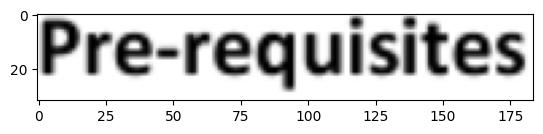

In [ ]:
ninth_word = non_overlapping_coordinates[4]
orginal_roi_9 = tmpImg[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
#plt.imshow(roi_9);

orginal_test_image = orginal_roi_9.copy()
plt.imshow(orginal_test_image, cmap='gray');

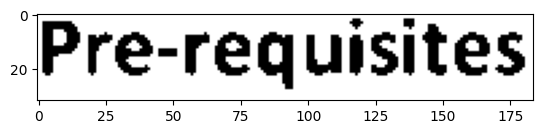

In [ ]:
# Threshold the image to create a binary image
_, binary_image = cv2.threshold(orginal_test_image, 128, 255, cv2.THRESH_BINARY)

# Define a kernel for dilation
kernel = np.ones((1, 1), np.uint8)

# Dilate the binary image to increase the black in the middle of characters
dilated_image = cv2.dilate(binary_image, kernel, iterations=2)

# Invert the dilated image to get the final result
result_image = cv2.bitwise_not(dilated_image)

plt.imshow(dilated_image);

In [ ]:
ninth_word = non_overlapping_coordinates[4]
roi_9 = imgWithoutTables[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
#plt.imshow(roi_9);

# Threshold the image to create a binary image
_, binary_image = cv2.threshold(roi_9, 128, 255, cv2.THRESH_BINARY)

# Define a kernel for dilation
kernel = np.ones((1, 1), np.uint8)

# Dilate the binary image to increase the black in the middle of characters
dilated_image = cv2.dilate(binary_image, kernel, iterations=2)


test_image = dilated_image.copy()
#plt.imshow(test_image, cmap='gray');

# Find contours in the binary image
contours, _ = cv2.findContours(test_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

sorted_contour_characters = sorted(contours, key=lambda cntr : cv2.boundingRect(cntr)[0])

# Create a folder to save individual character images
#import os
#output_folder = 'character_images'
#os.makedirs(output_folder, exist_ok=True)

# Iterate through the contours and save individual characters as images
#for i, contour in enumerate(contours):
    # Get the bounding box of the character
    #x, y, w, h = cv2.boundingRect(contour)

    # Crop the character from the original image
    #char_image = test_image[y:y + h, x:x + w]

    #cv2.rectangle(test_image, (x, y), (x + w, y + h), (0,0,255),2)

    # Save the character as a separate image
    #cv2.imwrite(os.path.join(output_folder, f'character_{i}.png'), char_image)
#plt.imshow(test_image);

character_list = []
for char in sorted_contour_characters:

  #if cv2.contourArea(word) < 400:
  #    continue

  x, y, w, h = cv2.boundingRect(char)
  character_list.append([x,y,w,h])


In [ ]:
#character_list = remove_overlapping(character_list)

In [ ]:
character_list

[[2, 2, 14, 21],
 [18, 7, 10, 16],
 [29, 7, 14, 16],
 [44, 13, 9, 4],
 [55, 7, 9, 16],
 [66, 7, 13, 16],
 [82, 7, 14, 22],
 [99, 7, 14, 16],
 [116, 7, 5, 16],
 [116, 1, 5, 5],
 [123, 7, 11, 16],
 [136, 7, 5, 16],
 [136, 1, 5, 5],
 [143, 3, 10, 20],
 [155, 7, 13, 16],
 [170, 7, 11, 16]]

In [ ]:
verticle_coordinate = []
for char in character_list:
  verticle_coordinate.append([char[0],char[0]+char[2]])

In [ ]:
verticle_coordinate

[[2, 16],
 [18, 28],
 [29, 43],
 [44, 53],
 [55, 64],
 [66, 79],
 [82, 96],
 [99, 113],
 [116, 121],
 [116, 121],
 [123, 134],
 [136, 141],
 [136, 141],
 [143, 153],
 [155, 168],
 [170, 181]]

In [ ]:
verticle_coordinate = remove_overlapping_characters(verticle_coordinate)

NameError: ignored

In [ ]:
# Load the image


# Define the x-coordinates where you want to draw vertical lines
#vertical_line_x_coordinates = [100, 200, 300]
vertical_line_x_coordinates = verticle_coordinate.copy()

# Define the color of the lines (BGR format, e.g., red is [0, 0, 255])
line_color = [255, 255, 255]

# Define the line thickness
line_thickness = 1

# Create a folder to save individual character images
import os
output_folder = '/content/gdrive/MyDrive/OWR/data/tmpCharacterSegment3'
os.makedirs(output_folder, exist_ok=True)

# Invert the dilated image to get the final result
result_image = cv2.bitwise_not(test_image)


# Draw the vertical lines
for i, x in enumerate(vertical_line_x_coordinates):
    # Crop the character from the original image
    x1, x2 = x
    char_image = result_image[: ,  x1 - 1:x2 + 1]
    print(char_image.shape)

    # Create a blank white canvas (32x32)
    canvas = np.ones((32, 32), dtype=np.uint8) * 255

    # Calculate the position to paste the image onto the center of the canvas
    x_offset = (canvas.shape[1] - char_image.shape[1]) // 2
    y_offset = (canvas.shape[0] - char_image.shape[0]) // 2

    # Paste the image onto the canvas
    canvas[y_offset:y_offset + char_image.shape[0], x_offset:x_offset + char_image.shape[1]] = char_image


    cv2.imwrite(os.path.join(output_folder, f'character_{i}.png'), canvas)

    print(f'print 2nd: {canvas.shape}')
    #cv2.line(test_image, (x, 0), (x, test_image.shape[0]), line_color, line_thickness)

# Save or display the image with vertical lines
#cv2.imwrite('image_with_vertical_lines.jpg', image)
#cv2.imshow('Image with Vertical Lines', test_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

#plt.imshow(test_image);



# Create a folder to save individual character images
#import os
#output_folder = 'character_images'
#os.makedirs(output_folder, exist_ok=True)

# Iterate through the contours and save individual characters as images
#for i, contour in enumerate(contours):
    # Get the bounding box of the character
    #x, y, w, h = cv2.boundingRect(contour)

    # Crop the character from the original image
    #char_image = test_image[y:y + h, x:x + w]

    #cv2.rectangle(test_image, (x, y), (x + w, y + h), (0,0,255),2)

    # Save the character as a separate image
    #cv2.imwrite(os.path.join(output_folder, f'character_{i}.png'), char_image)

(32, 16)
print 2nd: (32, 32)
(32, 12)
print 2nd: (32, 32)
(32, 16)
print 2nd: (32, 32)
(32, 11)
print 2nd: (32, 32)
(32, 11)
print 2nd: (32, 32)
(32, 15)
print 2nd: (32, 32)
(32, 16)
print 2nd: (32, 32)
(32, 16)
print 2nd: (32, 32)
(32, 7)
print 2nd: (32, 32)
(32, 7)
print 2nd: (32, 32)
(32, 13)
print 2nd: (32, 32)
(32, 7)
print 2nd: (32, 32)
(32, 7)
print 2nd: (32, 32)
(32, 12)
print 2nd: (32, 32)
(32, 15)
print 2nd: (32, 32)
(32, 13)
print 2nd: (32, 32)


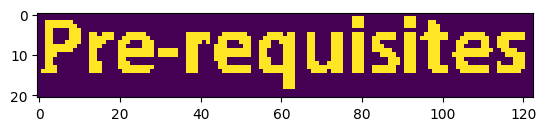

In [ ]:
#char = character_list[7]
#cv2.rectangle(test_image, (char[0], char[1]), (char[0] + char[2], char[1] + char[3]), (255,255,100),2)
plt.imshow(test_image);

For sorting the contours we will use the function provided by https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/. We will use top-to-bottom approach.

In [ ]:
# Find contours for image, which will detect all the boxes
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Sort all the contours by top to bottom.
#(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
#(contours, boundingBoxes) = sort_contours(contours)

In [ ]:
import cv2
import numpy as np

# Load your binary image (img_final_bin) here

# Find contours with hierarchy
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Initialize lists to store outer rectangles and their child contours
outer_rectangles = []
child_contours = []

# Iterate through the hierarchy to find outer rectangles and their children
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:  # Check if the contour has no parent (i.e., it's an outer contour)
        # Calculate the bounding rectangle of the outer contour
        x, y, w, h = cv2.boundingRect(contours[i])
        outer_rectangles.append((x, y, x + w, y + h))

        # Find child contours of the outer contour
        children = []
        for j in range(len(contours)):
            if hierarchy[0][j][3] == i:  # Check if contour j is a child of contour i
                children.append(j)
        child_contours.append(children)

# Now, outer_rectangles contains the bounding rectangles of the outer contours, and child_contours contains lists of child contour indices for each outer contour.


In [ ]:
cropped_dir_path = '/content/tmpImages2/'
idx = 0

for c in contours:
    # Returns the location and width,height for every contour
    x, y, w, h = cv2.boundingRect(c)


    if (w > 80 and h > 20) and w > 3*h:
        print(idx,x,y,w,h)
        idx += 1
        new_img = imgBinary[y:y+h, x:x+w]
        cv2.imwrite(cropped_dir_path+str(idx) + '.png', new_img)


0 110 102 1042 53
1 116 108 236 37
2 182 1064 706 118
3 189 1151 292 21
4 189 1124 292 21
5 189 1098 292 21
6 189 1071 292 21
7 357 108 786 37
8 486 1151 137 21
9 486 1124 137 21
10 486 1097 137 22
11 486 1071 137 21
12 629 1151 249 21
13 629 1124 249 21
14 629 1098 249 21
15 629 1071 249 21


## Module Testing

In [12]:
if __name__ == '__main__':
  def display_images(img1, img2, title1, title2, cmap1, cmap2):
    # Generating figure 1
    fig, axes = plt.subplots(1, 2, figsize=(15, 16))
    ax = axes.ravel()

    ax[0].imshow(img1, cmap=cmap1)
    ax[0].set_title(title1)
    ax[0].set_axis_off()

    ax[1].imshow(img2, cmap=cmap2)
    ax[1].set_title(title2)
    ax[1].set_axis_off()

    plt.show()

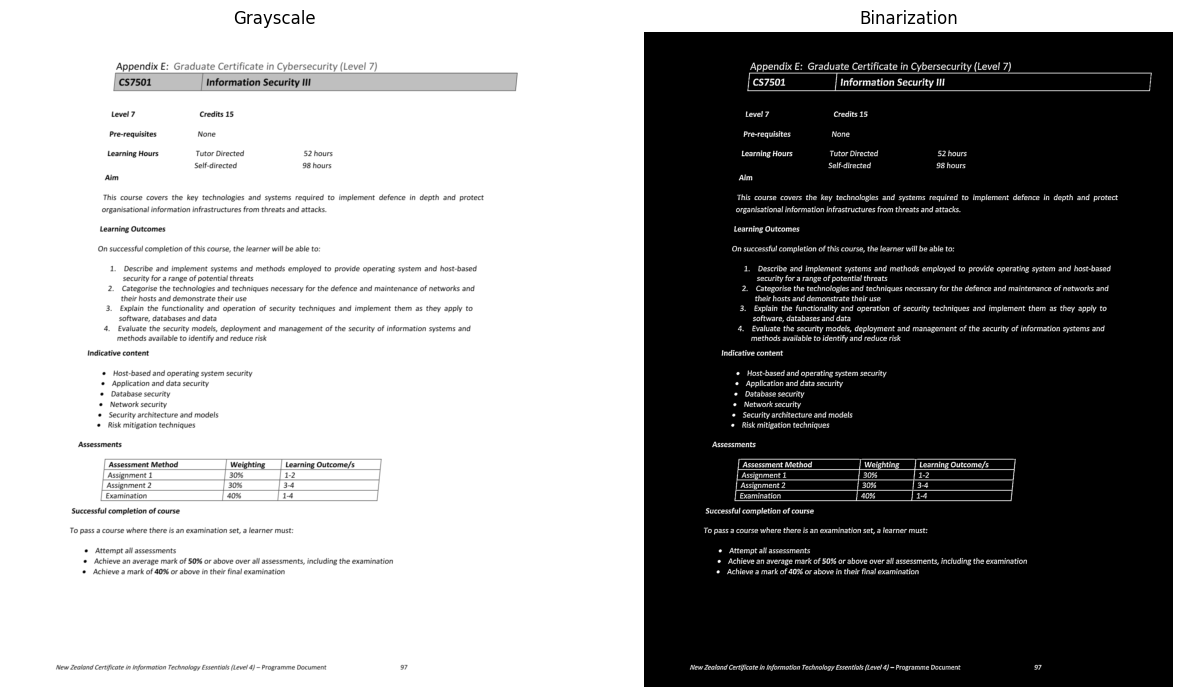

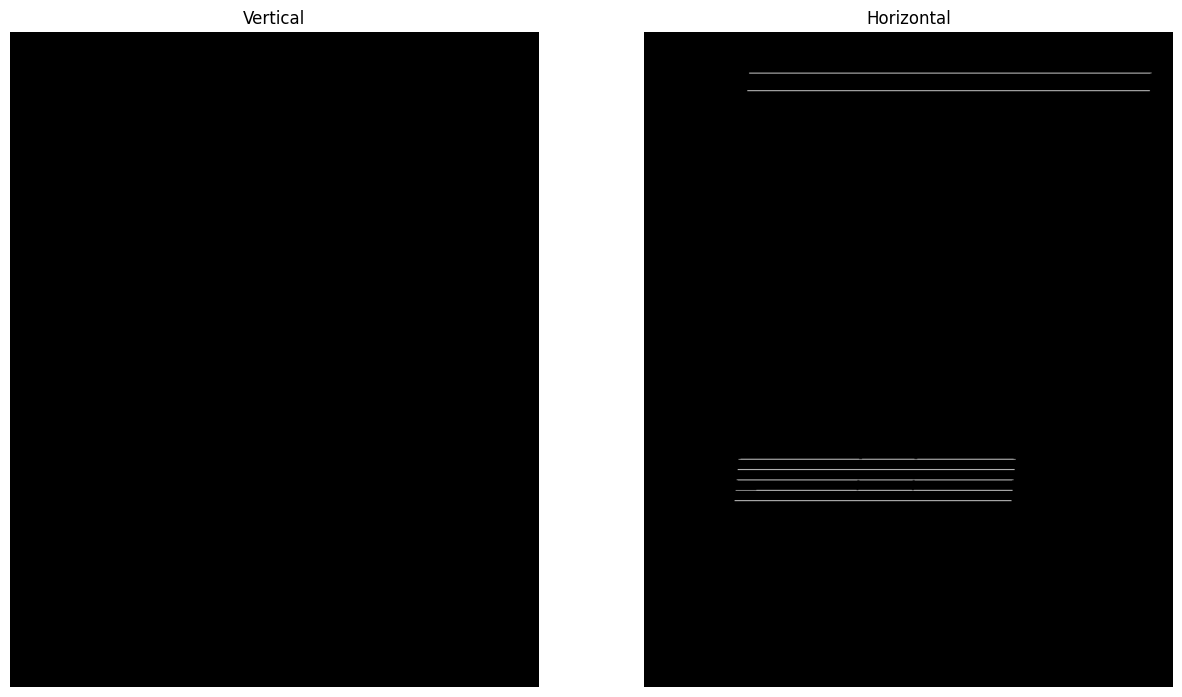

In [13]:
if __name__ == '__main__':
  display_images(imgGray, imgBinary, 'Grayscale', 'Binarization', 'gray', 'gray')
  display_images(vertical_lines_img, horizontal_lines_img, 'Vertical', 'Horizontal', 'gray', 'gray')


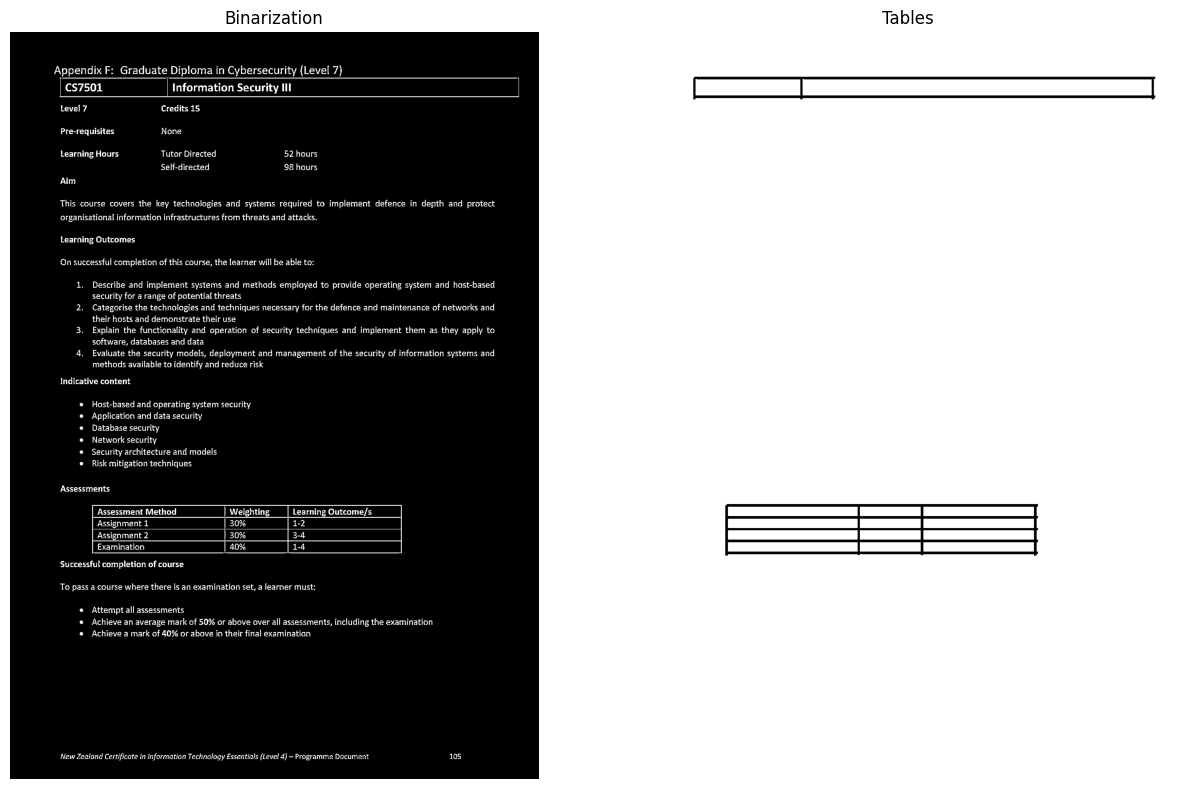

In [ ]:
if __name__ == '__main__':
  display_images(imgBinary, img_final_bin, 'Binarization', 'Tables', 'gray', 'gray')